# COVID-19 FORECASTING

We aim to predict the number of infections ($I_t$) and deaths ($D_t$) per country. For that, we account for the following variables:

- Goverment response index ($G_t$): real number, time dependent.
- Tracking and caring ($C_t$): binary time-dependent variable.
- Number of tests ($T_t$)
- Population ($\rho$)
- Density ($\delta$)
- Development ($\Delta$)
- Temperature ($\theta$)

Other variables:

- Policy trends
- Risk factors: smokers#
- Cultural factors
- Air pollution
- Population age
- Alcohol
- Medical care

In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as keb
from scipy.optimize import curve_fit
from datetime import datetime as dtime
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")

In [4]:
#loading data
#path = "../input/covid19-global-forecasting-week-3/"
path = ""
data = pd.read_csv(path+"train2.csv")
data.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [5]:
data["isCountry"] = data.Province_State.isna()
data.Province_State[data.Province_State.isna()] = ""
data["Region"]= data.Country_Region 
data["Region"][~data.isCountry]= data.Country_Region + "-" + data.Province_State


In [6]:
number_of_rows = data.shape[0]
registers_count_by_region = data[["Id", "Region"]].groupby("Region").count()
registers_count_by_region.columns = ["Count"]
registers_count_by_region.reset_index(inplace=True)#
days = np.unique(data.Date)
n_days = len(days)
regions = np.unique(data.Region)

print("Number of rows:", number_of_rows)

Number of rows: 23562


In [7]:
registers_count_by_region.head()

,Region,Count
0,Afghanistan,77
1,Albania,77
2,Algeria,77
3,Andorra,77
4,Angola,77


In [8]:
print("Days:", days)

Days: ['2020-01-22' '2020-01-23' '2020-01-24' '2020-01-25' '2020-01-26'
 '2020-01-27' '2020-01-28' '2020-01-29' '2020-01-30' '2020-01-31'
 '2020-02-01' '2020-02-02' '2020-02-03' '2020-02-04' '2020-02-05'
 '2020-02-06' '2020-02-07' '2020-02-08' '2020-02-09' '2020-02-10'
 '2020-02-11' '2020-02-12' '2020-02-13' '2020-02-14' '2020-02-15'
 '2020-02-16' '2020-02-17' '2020-02-18' '2020-02-19' '2020-02-20'
 '2020-02-21' '2020-02-22' '2020-02-23' '2020-02-24' '2020-02-25'
 '2020-02-26' '2020-02-27' '2020-02-28' '2020-02-29' '2020-03-01'
 '2020-03-02' '2020-03-03' '2020-03-04' '2020-03-05' '2020-03-06'
 '2020-03-07' '2020-03-08' '2020-03-09' '2020-03-10' '2020-03-11'
 '2020-03-12' '2020-03-13' '2020-03-14' '2020-03-15' '2020-03-16'
 '2020-03-17' '2020-03-18' '2020-03-19' '2020-03-20' '2020-03-21'
 '2020-03-22' '2020-03-23' '2020-03-24' '2020-03-25' '2020-03-26'
 '2020-03-27' '2020-03-28' '2020-03-29' '2020-03-30' '2020-03-31'
 '2020-04-01' '2020-04-02' '2020-04-03' '2020-04-04' '2020-04-05'
 '20

In [9]:
print("Countries:", regions)
print("No. Countries:", len(regions))

Countries: ['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia'
 'Australia-Australian Capital Territory' 'Australia-New South Wales'
 'Australia-Northern Territory' 'Australia-Queensland'
 'Australia-South Australia' 'Australia-Tasmania' 'Australia-Victoria'
 'Australia-Western Australia' 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain'
 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin' 'Bhutan'
 'Bolivia' 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'Brunei'
 'Bulgaria' 'Burkina Faso' 'Burma' 'Burundi' 'Cabo Verde' 'Cambodia'
 'Cameroon' 'Canada-Alberta' 'Canada-British Columbia' 'Canada-Manitoba'
 'Canada-New Brunswick' 'Canada-Newfoundland and Labrador'
 'Canada-Northwest Territories' 'Canada-Nova Scotia' 'Canada-Ontario'
 'Canada-Prince Edward Island' 'Canada-Quebec' 'Canada-Saskatchewan'
 'Canada-Yukon' 'Central African Republic' 'Chad' 'Chile' 'China-Anhui'
 'China-Beijing' 'China-Chongqing' 'China-Fujian' 'China-Gansu'
 'China-

In [10]:
print("No country - Regions:", data.Region[~data.isCountry])

No country - Regions: 616       Australia-Australian Capital Territory
617       Australia-Australian Capital Territory
618       Australia-Australian Capital Territory
619       Australia-Australian Capital Territory
620       Australia-Australian Capital Territory
                          ...                   
22941    United Kingdom-Turks and Caicos Islands
22942    United Kingdom-Turks and Caicos Islands
22943    United Kingdom-Turks and Caicos Islands
22944    United Kingdom-Turks and Caicos Islands
22945    United Kingdom-Turks and Caicos Islands
Name: Region, Length: 10010, dtype: object


In [11]:
max_confirmed_per_day_per_country = data[[ "Region", "ConfirmedCases" ]].groupby("Region").max()
max_confirmed_per_day_per_country.head()

,ConfirmedCases
Region,
Afghanistan,423.0
Albania,383.0
Algeria,1468.0
Andorra,545.0
Angola,17.0


In [12]:
#new confirmed column
data["Id_by_Region"] = data[["Region", "Id"]].groupby("Region").cumcount()
data["PreviousConfirmed"] = data["ConfirmedCases"].shift()
data.loc[ data.Id_by_Region==0, "PreviousConfirmed"] = 0
data["NewConfirmed"]= data.ConfirmedCases - data.PreviousConfirmed

#new fatalities column
data["Id_by_Region"] = data[["Region", "Id"]].groupby("Region").cumcount()
data["PreviousFatalities"] = data["Fatalities"].shift()
data.loc[ data.Id_by_Region==0,"PreviousFatalities"] = 0
data["NewFatalities"]= data.Fatalities - data.PreviousFatalities


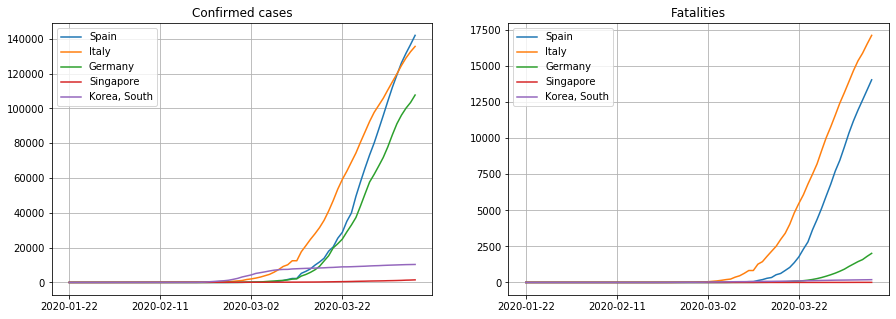

In [13]:
selected_countries = ["Spain", "Italy", "Germany", "Singapore", 'Korea, South']

fig, ax = plt.subplots(1,2, figsize=(15,5))

for i, country in enumerate(selected_countries):
    
    confirmed_country = data[data.Region==country].ConfirmedCases
    ax[0].plot(days, confirmed_country)
    ax[0].set_xticks(np.arange(0, n_days,20 ))
    
ax[0].legend(selected_countries)
ax[0].set_title("Confirmed cases")
ax[0].grid()

for i, country in enumerate(selected_countries):
    
    fatalities_country = data[data.Region==country].Fatalities
    ax[1].plot(days, fatalities_country)
    ax[1].set_xticks(np.arange(0, n_days,20 ))
    
ax[1].legend(selected_countries)
ax[1].set_title("Fatalities")
ax[1].grid()

<Figure size 432x288 with 0 Axes>

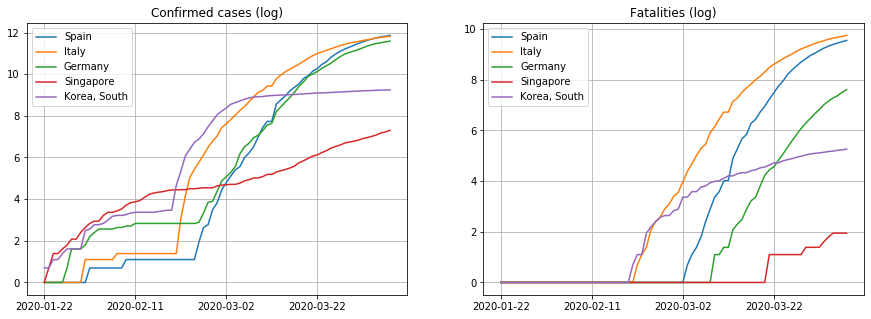

In [14]:
fig = plt.figure()

fig, ax = plt.subplots(1,2, figsize=(15,5))

for country in selected_countries:
    
    confirmed_country = np.log(data[data.Region==country].ConfirmedCases+1)
    ax[0].plot(days, confirmed_country)
    ax[0].set_xticks(np.arange(0, n_days,20 ))
ax[0].grid()
ax[0].legend(selected_countries)
ax[0].set_title("Confirmed cases (log)")

for i, country in enumerate(selected_countries):
    
    fatalities_country = np.log(data[data.Region==country].Fatalities+1)
    ax[1].plot(days, fatalities_country)
    ax[1].set_xticks(np.arange(0, n_days,20 ))
    
ax[1].legend(selected_countries)
ax[1].set_title("Fatalities (log)")
ax[1].grid()

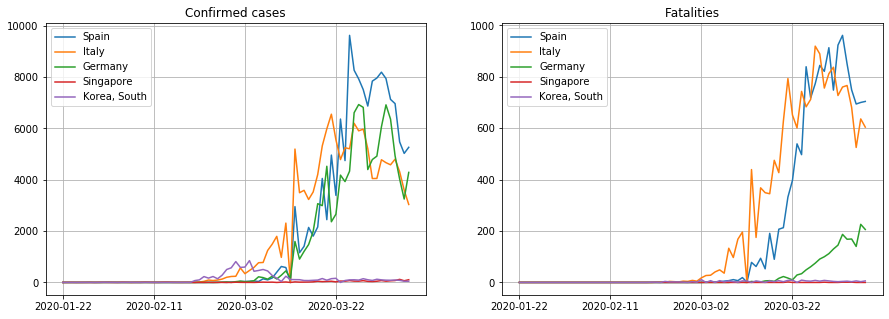

In [15]:

fig, ax = plt.subplots(1,2, figsize=(15,5))

for i, country in enumerate(selected_countries):
    
    confirmed_country = data[data.Region==country].NewConfirmed
    ax[0].plot(days, confirmed_country)
    ax[0].set_xticks(np.arange(0, n_days,20 ))
    
ax[0].legend(selected_countries)
ax[0].set_title("Confirmed cases")
ax[0].grid()

for i, country in enumerate(selected_countries):
    
    fatalities_country = data[data.Region==country].NewFatalities
    ax[1].plot(days, fatalities_country)
    ax[1].set_xticks(np.arange(0, n_days,20 ))
    
ax[1].legend(selected_countries)
ax[1].set_title("Fatalities")
ax[1].grid()

In [16]:
data["FirstConfirmed"] = data.apply(lambda x: x["ConfirmedCases"]>0, axis=1)
data["FirstFatality"] = data.apply(lambda x: x["Fatalities"]>0, axis=1)
data["DayFromFirstConfirmed"] = data[["FirstConfirmed", "Region"]].groupby("Region").cumsum()
data["DayFromFirstFatality"] = data[["FirstFatality", "Region"]].groupby("Region").cumsum()

data["TenConfirmed"] = data.apply(lambda x: x["ConfirmedCases"]>10, axis=1)
data["TenFatality"] = data.apply(lambda x: x["Fatalities"]>10, axis=1)
data["DayFromTenConfirmed"] = data[["TenConfirmed", "Region"]].groupby("Region").cumsum()
data["DayFromTenFatality"] = data[["TenFatality", "Region"]].groupby("Region").cumsum()

data["LogNewConfirmed"] = np.log(data["NewConfirmed"]+1) 
data["LogNewFatalities"] = np.log(data["NewFatalities"]+1)

In [17]:
first_day_confirmed = data[data["DayFromTenConfirmed"] == 1][["Region", "Date"]]
first_day_confirmed.head()

,Region,Date
52,Afghanistan,2020-03-14
126,Albania,2020-03-11
196,Algeria,2020-03-04
286,Andorra,2020-03-17
382,Angola,2020-04-05


In [18]:
first_day_fatality = data[data["DayFromTenFatality"] == 1][["Region", "Date"]]
first_day_fatality.head()

,Region,Date
75,Afghanistan,2020-04-06
145,Albania,2020-03-30
212,Algeria,2020-03-20
300,Andorra,2020-03-31
527,Argentina,2020-03-27


In [19]:
df_merged = pd.merge(first_day_confirmed, first_day_fatality, on='Region', how='left')
print("Number of unique regions:", df_merged.shape[0])
df_merged.head()

def to_datetime(x):
    try: 
        return dtime.strptime(x,  "%Y-%m-%d")
    except: 
        return pd.NaT

df_merged.Date_x = df_merged.Date_x.apply(lambda x: dtime.strptime(x,  "%Y-%m-%d"))
df_merged.Date_y = df_merged.Date_y.apply(lambda x: to_datetime(x))
df_merged["DifferenceFirstConfirmedFatality"] = df_merged.Date_y - df_merged.Date_x
df_merged.head()

Number of unique regions: 277


,Region,Date_x,Date_y,DifferenceFirstConfirmedFatality
0,Afghanistan,2020-03-14,2020-04-06,23 days
1,Albania,2020-03-11,2020-03-30,19 days
2,Algeria,2020-03-04,2020-03-20,16 days
3,Andorra,2020-03-17,2020-03-31,14 days
4,Angola,2020-04-05,NaT,NaT


## Simple Models

[17.483203624942153,
 17.467602281493175,
 0.5817619654963399,
 0.11214836554190367,
 16.652614180425015]

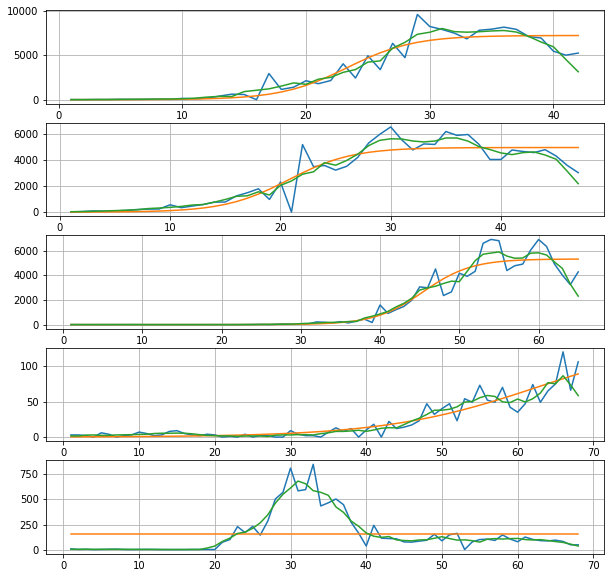

In [20]:

fig, ax = plt.subplots(len(selected_countries),1, figsize=(10,10))
error = []
N = 5

def sigmoid(x, a, x0, k):
    y = a / (1 + np.exp(-k*(x-x0)))
    return y

def exponential(x, a, x0, k):
    y = a*np.exp(-k*(x-x0))
    return y

    
for i, country in enumerate(selected_countries):
    
    data_region = data[data.Region == country][data.TenConfirmed==True]

    y = data_region.NewConfirmed
    x = data_region.DayFromTenConfirmed
    ma = np.convolve(y, np.ones((N,))/N, mode='same')

    popt, pcov = curve_fit(sigmoid, x, y)
    confirmed_fitted_sigmoid = sigmoid(x, *popt)
    
    error.append(np.median((confirmed_fitted_sigmoid-ma)**2)/np.max(ma))

    ax[i].plot(x, y)
    ax[i].plot(x, confirmed_fitted_sigmoid)
    ax[i].plot(x, ma)
    ax[i].grid()
error

In [21]:
error_regions = []
for i, country in enumerate(regions):
    
    data_region = data[data.Region == country][data.TenConfirmed==True]



    try:
        y = data_region.NewConfirmed
        x = data_region.DayFromTenConfirmed
        ma = np.convolve(y, np.ones((N,))/N, mode='same')
        popt, pcov = curve_fit(sigmoid, x, y)
        confirmed_fitted_sigmoid = sigmoid(x, *popt)

        error_regions.append(np.median((confirmed_fitted_sigmoid-ma)**2)/np.max(ma))
    except:
        error_regions.append(np.nan)



In [22]:
state_index = pd.DataFrame({"Region": regions, "state_index": error_regions})
df_merged = pd.merge(df_merged, state_index, on='Region', how='left')

In [23]:
interesting_regions = df_merged[df_merged.state_index>20].Region

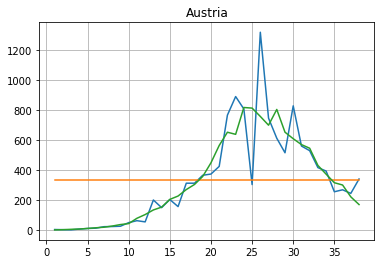

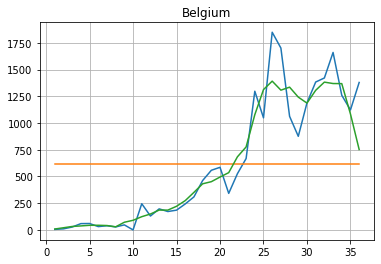

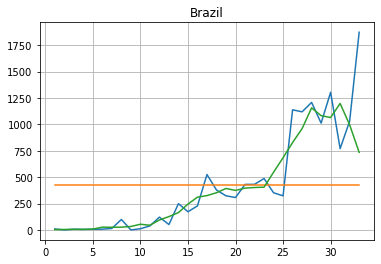

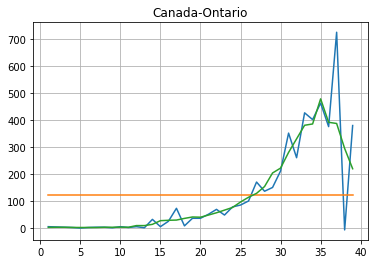

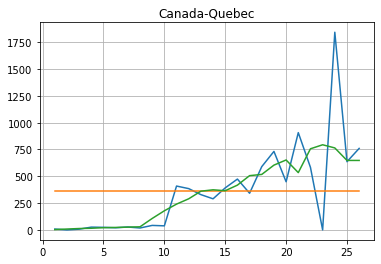

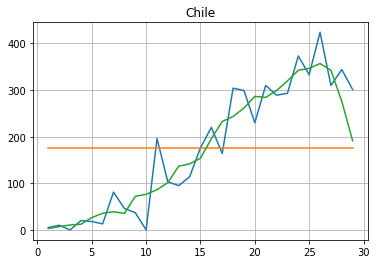

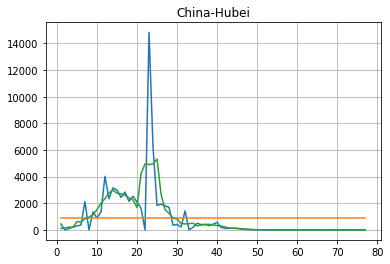

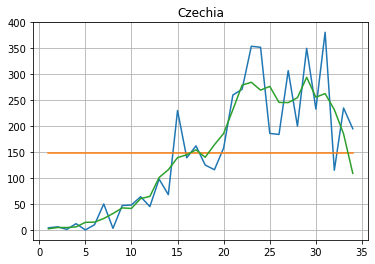

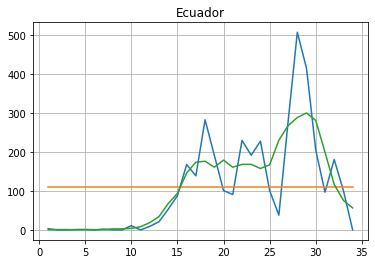

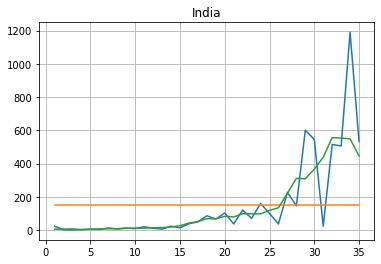

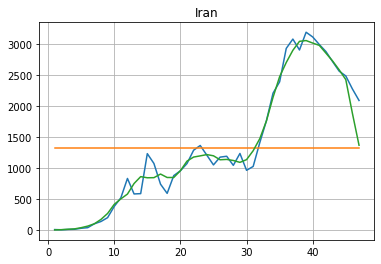

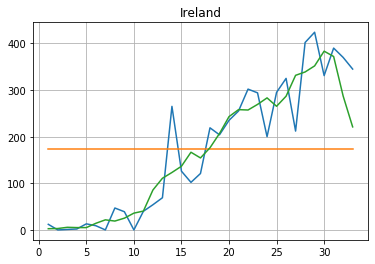

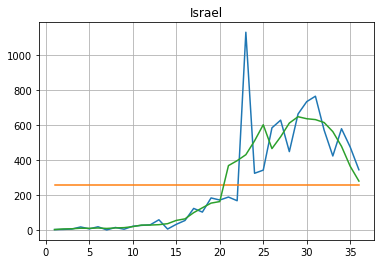

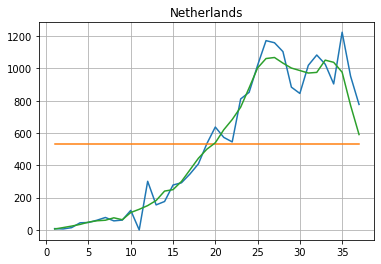

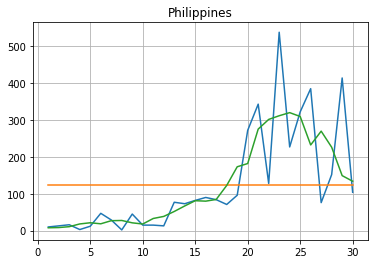

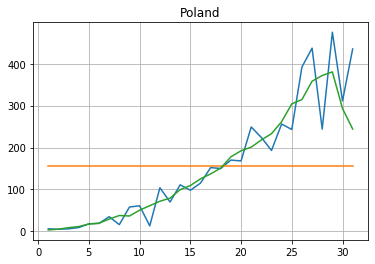

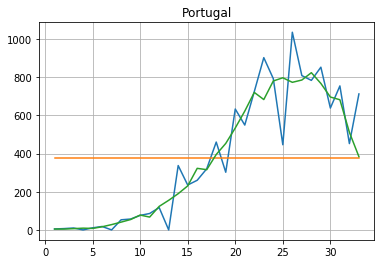

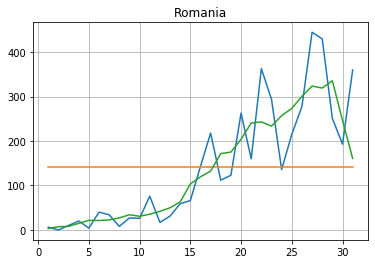

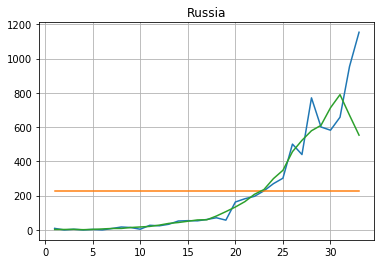

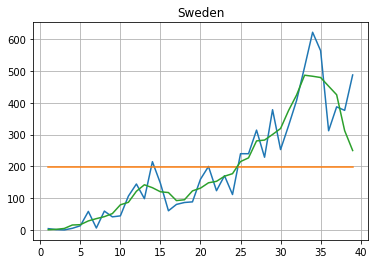

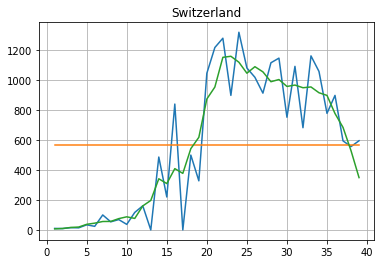

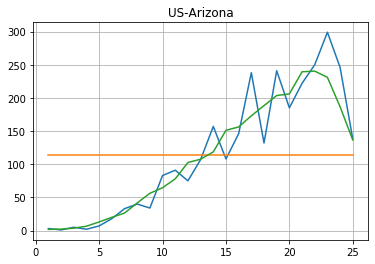

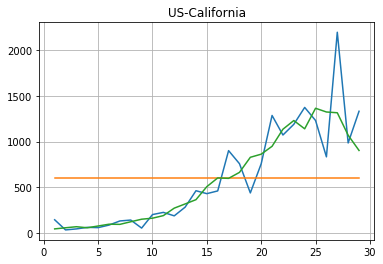

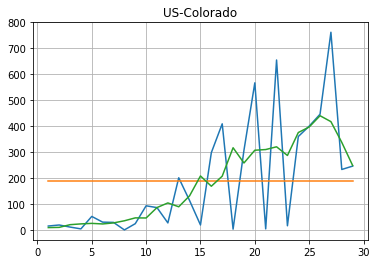

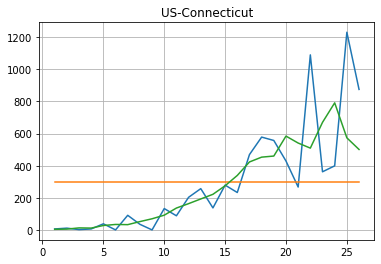

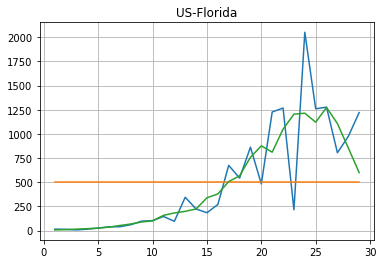

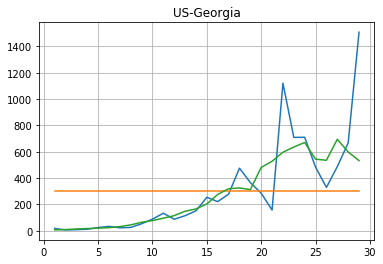

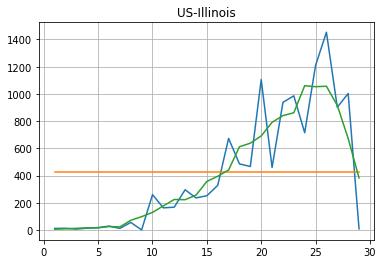

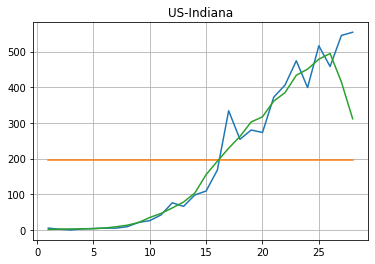

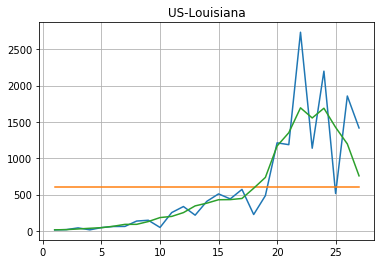

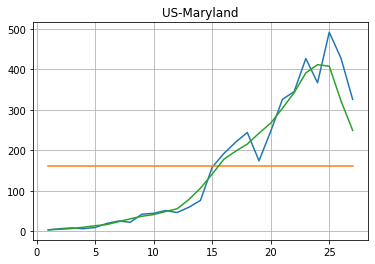

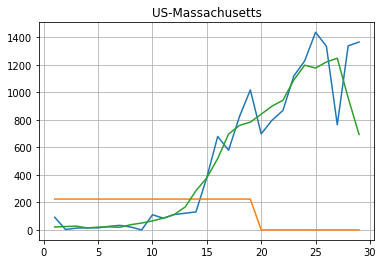

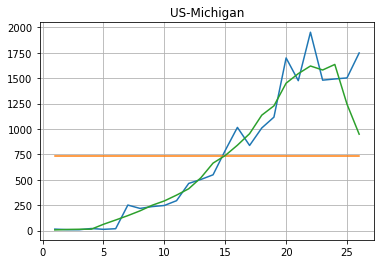

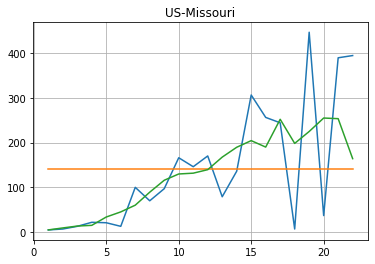

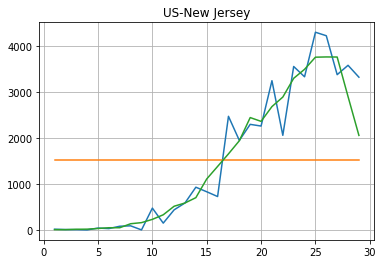

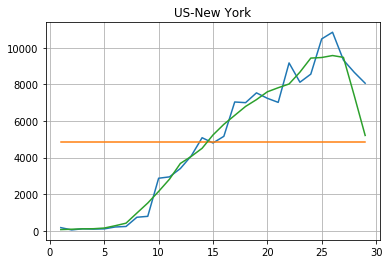

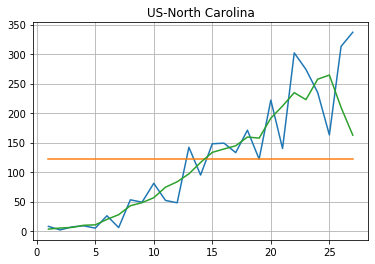

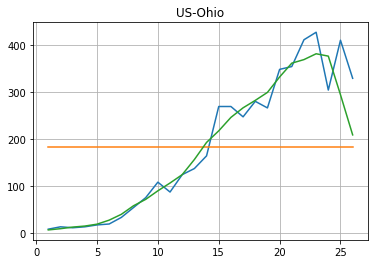

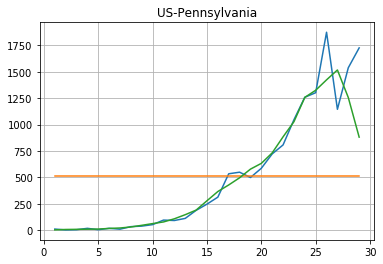

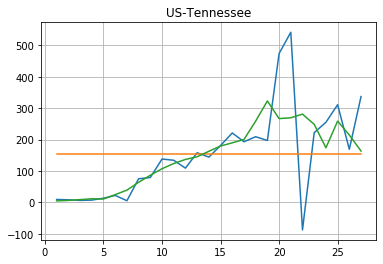

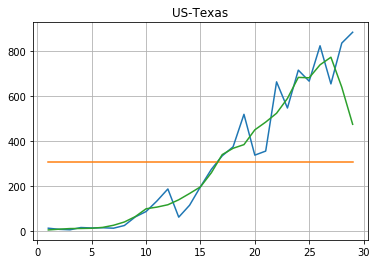

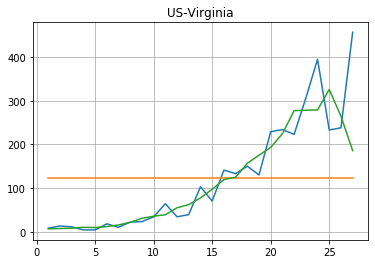

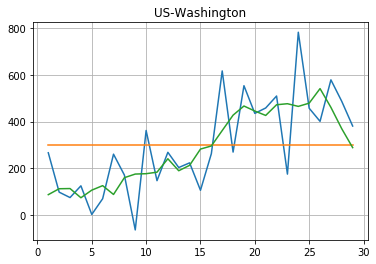

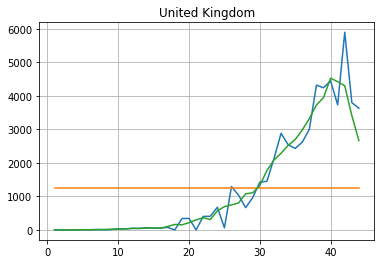

In [28]:


for i, country in enumerate(interesting_regions):
    
    fig = plt.figure()
    data_region = data[data.Region == country][data.TenConfirmed==True]

    y = data_region.NewConfirmed
    x = data_region.DayFromTenConfirmed
    ma = np.convolve(y, np.ones((N,))/N, mode='same')

    popt, pcov = curve_fit(sigmoid, x, y)
    confirmed_fitted_sigmoid = sigmoid(x, *popt)
    
    error.append(np.median((confirmed_fitted_sigmoid-ma)**2)/np.max(ma))

    plt.plot(x, y)
    plt.plot(x, confirmed_fitted_sigmoid)
    plt.plot(x, ma)
    plt.grid()
    plt.title(country)


In [29]:
selected_countries

['Spain', 'Italy', 'Germany', 'Singapore', 'Korea, South']

In [30]:
data_region = data[data.Region == "Korea, South"][data.TenConfirmed==True]

In [31]:
np.median(data_region.NewConfirmed)

90.0

In [32]:
error_regions_exponential = []
error_regions_sigmoid = []

for i, country in enumerate(regions):
    
    data_region = data[data.Region == country][data.TenConfirmed==True]


    try:
        y = data_region.NewConfirmed
        x = data_region.DayFromTenConfirmed
        ma = np.convolve(y, np.ones((N,))/N, mode='same')
        

        popt, pcov = curve_fit(sigmoid, x, y)
        confirmed_fitted_sigmoid = sigmoid(x, *popt)
        
        error_regions_sigmoid.append(np.median((confirmed_fitted_sigmoid-ma)**2)/np.max(ma))
    except:
        
        error_regions_sigmoid.append(np.nan)
        

    try:
        y = data_region.NewConfirmed
        x = data_region.DayFromTenConfirmed
        ma = np.convolve(y, np.ones((N,))/N, mode='same')
        

        popt, pcov = curve_fit(sigmoid, x, y)
        confirmed_fitted_exponential = exponential(x, *popt)
        
        error_regions_exponential.append(np.median((confirmed_fitted_exponential-ma)**2)/np.max(ma))
    except:
        
        error_regions_exponential.append(np.nan)
        
        


In [33]:
state_index = pd.DataFrame({"Region": regions, "sigmoid_error": error_regions_sigmoid, 
                            "exponential_error": error_regions_exponential})

df_merged2 = pd.merge(df_merged, state_index, on='Region', how='left')
df_merged2["state"] = df_merged2[["sigmoid_error", "exponential_error"]].apply(lambda x: int(x[0]< x[1]), axis=1)

In [34]:
df_merged2

,Region,Date_x,Date_y,DifferenceFirstConfirmedFatality,state_index,sigmoid_error,exponential_error,state
0,Afghanistan,2020-03-14,2020-04-06,23 days,0.287464,0.287464,340.575693,1
1,Albania,2020-03-11,2020-03-30,19 days,1.617998,1.617998,8.550847,1
2,Algeria,2020-03-04,2020-03-20,16 days,0.116369,0.116369,1215.475849,1
3,Andorra,2020-03-17,2020-03-31,14 days,0.861922,0.861922,14.537363,1
4,Angola,2020-04-05,NaT,NaT,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
272,Venezuela,2020-03-16,NaT,NaT,0.223483,0.223483,4.362264,1
273,Vietnam,2020-02-08,NaT,NaT,0.055504,0.055504,25.800343,1
274,West Bank and Gaza,2020-03-07,NaT,NaT,1.143392,1.143392,0.741667,0
275,Zambia,2020-03-25,NaT,NaT,0.675432,0.675432,0.850000,1


In [35]:
df_merged2[df_merged2.Region=="Colombia"]

,Region,Date_x,Date_y,DifferenceFirstConfirmedFatality,state_index,sigmoid_error,exponential_error,state
77,Colombia,2020-03-13,2020-03-30,17 days,10.478,10.478,34.339257,1


In [36]:
def simple_predictor(func, ts1, ts2, c1, c2, h):
    
    x_past1 = np.arange(len(ts1))
    x_past2 = np.arange(len(ts2))
    
    x_fut = np.arange(c1,h+c1,1)
    
    popt, pcov = curve_fit(func, x_past1, ts1)
    p1 = sigmoid(x_fut, *popt)

    popt, pcov = curve_fit(func, x_past2, ts2)
    p2 = sigmoid(x_fut, *popt)
    
    return p1, p2
    

## Simple RNN

In [16]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)


def RMSLE (y_pred,  y_true):
    
    return keb.mean(keb.square(keb.log(y_pred+1)-keb.log(y_true+1)))
    


In [25]:
datasets = []
norm_factor = 100

for region in regions:
    datasets.append(np.array(data[["NewConfirmed", "NewFatalities"]][data.TenConfirmed==1][data.Region==region]))
    
len_data = len(datasets)

C:\Users\Sebastian\Anaconda3\envs\tf1-gpu\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [26]:
past_history = 7
future_target = 1
STEP = 1

BATCH_SIZE = 10
BUFFER_SIZE = 10
EPOCHS = 0
EVALUATION_INTERVAL = 1
THRESHOLD_REGION = 15

x_train = []
y_train = []
x_val = []
y_val = []

for dataset in datasets:
    
    if (dataset.shape[0]>THRESHOLD_REGION):
        len_data= dataset.shape[0]
        TRAIN_SPLIT = int(len_data*0.6)
        x_train_temp, y_train_temp = multivariate_data(dataset, dataset[:,0], 0, TRAIN_SPLIT, past_history, future_target, STEP)

        x_train.append(x_train_temp)
        y_train.append(y_train_temp)
        
        x_val_temp, y_val_temp = multivariate_data(dataset, dataset[:,0], TRAIN_SPLIT, None, past_history, future_target, STEP)
        
        if(x_val_temp.shape[0]>0):
            x_val.append(x_val_temp)
            y_val.append(y_val_temp)
            

In [27]:
x_train = np.concatenate(x_train, axis=0)
y_train = np.vstack(y_train)


print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_val = np.concatenate(x_val, axis=0)
y_val = np.vstack(y_val)


print("x_train shape:", x_val.shape)
print("y_train shape:", y_val.shape)

x_train shape: (2359, 7, 2)
y_train shape: (2359, 1)
x_train shape: (1082, 7, 2)
y_train shape: (1082, 1)


In [28]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [29]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(16,
                                          return_sequences=True,
                                          input_shape=x_train.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(8, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001, clipvalue=1.0), loss=RMSLE)

In [30]:
multi_step_history = multi_step_model.fit(train_data, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data,
                                          validation_steps=10)

Train on 1 steps, validate on 10 steps
Epoch 1/10000
1/1 [==============================] - 3s 3s/step - loss: 5.8774 - val_loss: 16.0441
Epoch 2/10000
1/1 [==============================] - 0s 144ms/step - loss: 5.5572 - val_loss: 16.0334
Epoch 3/10000
1/1 [==============================] - 0s 130ms/step - loss: 9.8710 - val_loss: 16.0229
Epoch 4/10000
1/1 [==============================] - 0s 156ms/step - loss: 9.0931 - val_loss: 16.0146
Epoch 5/10000
1/1 [==============================] - 0s 170ms/step - loss: 8.5075 - val_loss: 16.0082
Epoch 6/10000
1/1 [==============================] - 0s 159ms/step - loss: 7.8981 - val_loss: 16.0023
Epoch 7/10000
1/1 [==============================] - 0s 158ms/step - loss: 9.7323 - val_loss: 15.9962
Epoch 8/10000
1/1 [==============================] - 0s 173ms/step - loss: 15.7737 - val_loss: 15.9890
Epoch 9/10000
1/1 [==============================] - 0s 157ms/step - loss: 15.3022 - val_loss: 15.9828
Epoch 10/10000
1/1 [========================

1/1 [==============================] - 0s 160ms/step - loss: 8.4353 - val_loss: 15.7469
Epoch 81/10000
1/1 [==============================] - 0s 158ms/step - loss: 10.6886 - val_loss: 15.7423
Epoch 82/10000
1/1 [==============================] - 0s 169ms/step - loss: 1.0125 - val_loss: 15.7409
Epoch 83/10000
1/1 [==============================] - 0s 146ms/step - loss: 1.8265 - val_loss: 15.7389
Epoch 84/10000
1/1 [==============================] - 0s 167ms/step - loss: 0.8016 - val_loss: 15.7374
Epoch 85/10000
1/1 [==============================] - 0s 159ms/step - loss: 0.1677 - val_loss: 15.7371
Epoch 86/10000
1/1 [==============================] - 0s 161ms/step - loss: 1.0425 - val_loss: 15.7356
Epoch 87/10000
1/1 [==============================] - 0s 166ms/step - loss: 2.4037 - val_loss: 15.7332
Epoch 88/10000
1/1 [==============================] - 0s 158ms/step - loss: 0.3321 - val_loss: 15.7325
Epoch 89/10000
1/1 [==============================] - 0s 160ms/step - loss: 0.8223 - va

Epoch 159/10000
1/1 [==============================] - 0s 162ms/step - loss: 8.3248 - val_loss: 15.4974
Epoch 160/10000
1/1 [==============================] - 0s 151ms/step - loss: 6.6364 - val_loss: 15.4947
Epoch 161/10000
1/1 [==============================] - 0s 165ms/step - loss: 4.8875 - val_loss: 15.4925
Epoch 162/10000
1/1 [==============================] - 0s 169ms/step - loss: 11.1061 - val_loss: 15.4897
Epoch 163/10000
1/1 [==============================] - 0s 169ms/step - loss: 21.4670 - val_loss: 15.4853
Epoch 164/10000
1/1 [==============================] - 0s 165ms/step - loss: 21.2754 - val_loss: 15.4811
Epoch 165/10000
1/1 [==============================] - 0s 158ms/step - loss: 9.6387 - val_loss: 15.4782
Epoch 166/10000
1/1 [==============================] - 0s 158ms/step - loss: 5.1694 - val_loss: 15.4759
Epoch 167/10000
1/1 [==============================] - 0s 147ms/step - loss: 9.2381 - val_loss: 15.4728
Epoch 168/10000
1/1 [==============================] - 0s 159

Epoch 238/10000
1/1 [==============================] - 0s 151ms/step - loss: 5.5788 - val_loss: 15.2552
Epoch 239/10000
1/1 [==============================] - 0s 138ms/step - loss: 9.0061 - val_loss: 15.2516
Epoch 240/10000
1/1 [==============================] - 0s 132ms/step - loss: 8.5800 - val_loss: 15.2480
Epoch 241/10000
1/1 [==============================] - 0s 131ms/step - loss: 8.4266 - val_loss: 15.2446
Epoch 242/10000
1/1 [==============================] - 0s 154ms/step - loss: 8.2485 - val_loss: 15.2412
Epoch 243/10000
1/1 [==============================] - 0s 148ms/step - loss: 8.8788 - val_loss: 15.2376
Epoch 244/10000
1/1 [==============================] - 0s 169ms/step - loss: 14.9394 - val_loss: 15.2335
Epoch 245/10000
1/1 [==============================] - 0s 149ms/step - loss: 14.4157 - val_loss: 15.2291
Epoch 246/10000
1/1 [==============================] - 0s 154ms/step - loss: 5.2820 - val_loss: 15.2265
Epoch 247/10000
1/1 [==============================] - 0s 166m

Epoch 317/10000
1/1 [==============================] - 0s 162ms/step - loss: 5.0318 - val_loss: 15.0011
Epoch 318/10000
1/1 [==============================] - 0s 157ms/step - loss: 4.0107 - val_loss: 14.9979
Epoch 319/10000
1/1 [==============================] - 0s 156ms/step - loss: 3.1926 - val_loss: 14.9949
Epoch 320/10000
1/1 [==============================] - 0s 157ms/step - loss: 0.7930 - val_loss: 14.9938
Epoch 321/10000
1/1 [==============================] - 0s 155ms/step - loss: 0.2278 - val_loss: 14.9933
Epoch 322/10000
1/1 [==============================] - 0s 166ms/step - loss: 1.4158 - val_loss: 14.9917
Epoch 323/10000
1/1 [==============================] - 0s 180ms/step - loss: 2.0911 - val_loss: 14.9896
Epoch 324/10000
1/1 [==============================] - 0s 156ms/step - loss: 0.3295 - val_loss: 14.9891
Epoch 325/10000
1/1 [==============================] - 0s 167ms/step - loss: 0.3967 - val_loss: 14.9886
Epoch 326/10000
1/1 [==============================] - 0s 168ms/

Epoch 396/10000
1/1 [==============================] - 0s 159ms/step - loss: 7.5574 - val_loss: 14.7272
Epoch 397/10000
1/1 [==============================] - 0s 178ms/step - loss: 4.4167 - val_loss: 14.7243
Epoch 398/10000
1/1 [==============================] - 0s 161ms/step - loss: 14.1947 - val_loss: 14.7203
Epoch 399/10000
1/1 [==============================] - 0s 162ms/step - loss: 18.7556 - val_loss: 14.7160
Epoch 400/10000
1/1 [==============================] - 0s 174ms/step - loss: 16.1088 - val_loss: 14.7118
Epoch 401/10000
1/1 [==============================] - 0s 162ms/step - loss: 12.1691 - val_loss: 14.7078
Epoch 402/10000
1/1 [==============================] - 0s 168ms/step - loss: 4.4609 - val_loss: 14.7051
Epoch 403/10000
1/1 [==============================] - 0s 166ms/step - loss: 12.9085 - val_loss: 14.7003
Epoch 404/10000
1/1 [==============================] - 0s 160ms/step - loss: 8.5378 - val_loss: 14.6965
Epoch 405/10000
1/1 [==============================] - 0s 1

Epoch 475/10000
1/1 [==============================] - 0s 169ms/step - loss: 8.5898 - val_loss: 14.4315
Epoch 476/10000
1/1 [==============================] - 0s 156ms/step - loss: 7.9149 - val_loss: 14.4272
Epoch 477/10000
1/1 [==============================] - 0s 160ms/step - loss: 6.8215 - val_loss: 14.4239
Epoch 478/10000
1/1 [==============================] - 0s 162ms/step - loss: 8.2054 - val_loss: 14.4198
Epoch 479/10000
1/1 [==============================] - 0s 160ms/step - loss: 5.8699 - val_loss: 14.4165
Epoch 480/10000
1/1 [==============================] - 0s 167ms/step - loss: 13.2097 - val_loss: 14.4116
Epoch 481/10000
1/1 [==============================] - 0s 118ms/step - loss: 15.5588 - val_loss: 14.4069
Epoch 482/10000
1/1 [==============================] - 0s 110ms/step - loss: 7.6994 - val_loss: 14.4037
Epoch 483/10000
1/1 [==============================] - 0s 167ms/step - loss: 4.3409 - val_loss: 14.4012
Epoch 484/10000
1/1 [==============================] - 0s 159m

Epoch 554/10000
1/1 [==============================] - 0s 157ms/step - loss: 2.3747 - val_loss: 14.1459
Epoch 555/10000
1/1 [==============================] - 0s 159ms/step - loss: 1.8158 - val_loss: 14.1433
Epoch 556/10000
1/1 [==============================] - 0s 154ms/step - loss: 0.2031 - val_loss: 14.1427
Epoch 557/10000
1/1 [==============================] - 0s 163ms/step - loss: 0.1433 - val_loss: 14.1426
Epoch 558/10000
1/1 [==============================] - 0s 171ms/step - loss: 1.9400 - val_loss: 14.1393
Epoch 559/10000
1/1 [==============================] - 0s 136ms/step - loss: 0.9706 - val_loss: 14.1370
Epoch 560/10000
1/1 [==============================] - 0s 148ms/step - loss: 0.5222 - val_loss: 14.1359
Epoch 561/10000
1/1 [==============================] - 0s 151ms/step - loss: 0.2968 - val_loss: 14.1355
Epoch 562/10000
1/1 [==============================] - 0s 160ms/step - loss: 1.3466 - val_loss: 14.1332
Epoch 563/10000
1/1 [==============================] - 0s 146ms/

Epoch 633/10000
1/1 [==============================] - 0s 176ms/step - loss: 3.4799 - val_loss: 13.8248
Epoch 634/10000
1/1 [==============================] - 0s 168ms/step - loss: 13.6250 - val_loss: 13.8204
Epoch 635/10000
1/1 [==============================] - 0s 163ms/step - loss: 20.7595 - val_loss: 13.8154
Epoch 636/10000
1/1 [==============================] - 0s 171ms/step - loss: 20.3027 - val_loss: 13.8103
Epoch 637/10000
1/1 [==============================] - 0s 170ms/step - loss: 3.9299 - val_loss: 13.8071
Epoch 638/10000
1/1 [==============================] - 0s 165ms/step - loss: 4.4200 - val_loss: 13.8037
Epoch 639/10000
1/1 [==============================] - 0s 138ms/step - loss: 6.6039 - val_loss: 13.7990
Epoch 640/10000
1/1 [==============================] - 0s 172ms/step - loss: 6.9037 - val_loss: 13.7950
Epoch 641/10000
1/1 [==============================] - 0s 177ms/step - loss: 2.9817 - val_loss: 13.7929
Epoch 642/10000
1/1 [==============================] - 0s 174

Epoch 712/10000
1/1 [==============================] - 0s 166ms/step - loss: 7.5197 - val_loss: 13.4721
Epoch 713/10000
1/1 [==============================] - 0s 168ms/step - loss: 5.6220 - val_loss: 13.4675
Epoch 714/10000
1/1 [==============================] - 0s 163ms/step - loss: 6.5174 - val_loss: 13.4627
Epoch 715/10000
1/1 [==============================] - 0s 165ms/step - loss: 8.1559 - val_loss: 13.4573
Epoch 716/10000
1/1 [==============================] - 0s 175ms/step - loss: 11.9222 - val_loss: 13.4509
Epoch 717/10000
1/1 [==============================] - 0s 160ms/step - loss: 14.5601 - val_loss: 13.4453
Epoch 718/10000
1/1 [==============================] - 0s 155ms/step - loss: 3.0693 - val_loss: 13.4427
Epoch 719/10000
1/1 [==============================] - 0s 165ms/step - loss: 4.8756 - val_loss: 13.4394
Epoch 720/10000
1/1 [==============================] - 0s 175ms/step - loss: 7.2930 - val_loss: 13.4347
Epoch 721/10000
1/1 [==============================] - 0s 172m

Epoch 792/10000
1/1 [==============================] - 0s 86ms/step - loss: 1.3484 - val_loss: 13.1162
Epoch 793/10000
1/1 [==============================] - 0s 82ms/step - loss: 0.1160 - val_loss: 13.1163
Epoch 794/10000
1/1 [==============================] - 0s 87ms/step - loss: 1.3597 - val_loss: 13.1128
Epoch 795/10000
1/1 [==============================] - 0s 81ms/step - loss: 1.0727 - val_loss: 13.1089
Epoch 796/10000
1/1 [==============================] - 0s 88ms/step - loss: 0.3138 - val_loss: 13.1082
Epoch 797/10000
1/1 [==============================] - 0s 81ms/step - loss: 0.5058 - val_loss: 13.1067
Epoch 798/10000
1/1 [==============================] - 0s 84ms/step - loss: 0.8052 - val_loss: 13.1045
Epoch 799/10000
1/1 [==============================] - 0s 84ms/step - loss: 0.6550 - val_loss: 13.1032
Epoch 800/10000
1/1 [==============================] - 0s 80ms/step - loss: 0.1129 - val_loss: 13.1034
Epoch 801/10000
1/1 [==============================] - 0s 81ms/step - los

Epoch 872/10000
1/1 [==============================] - 0s 92ms/step - loss: 13.8423 - val_loss: 12.6890
Epoch 873/10000
1/1 [==============================] - 0s 87ms/step - loss: 8.7517 - val_loss: 12.6840
Epoch 874/10000
1/1 [==============================] - 0s 97ms/step - loss: 2.8519 - val_loss: 12.6801
Epoch 875/10000
1/1 [==============================] - 0s 84ms/step - loss: 7.6519 - val_loss: 12.6732
Epoch 876/10000
1/1 [==============================] - 0s 86ms/step - loss: 9.1967 - val_loss: 12.6666
Epoch 877/10000
1/1 [==============================] - 0s 87ms/step - loss: 2.0626 - val_loss: 12.6647
Epoch 878/10000
1/1 [==============================] - 0s 80ms/step - loss: 2.3315 - val_loss: 12.6616
Epoch 879/10000
1/1 [==============================] - 0s 85ms/step - loss: 2.9160 - val_loss: 12.6579
Epoch 880/10000
1/1 [==============================] - 0s 92ms/step - loss: 5.2239 - val_loss: 12.6510
Epoch 881/10000
1/1 [==============================] - 0s 83ms/step - lo

Epoch 952/10000
1/1 [==============================] - 0s 162ms/step - loss: 10.4672 - val_loss: 12.2141
Epoch 953/10000
1/1 [==============================] - 0s 158ms/step - loss: 14.7987 - val_loss: 12.2048
Epoch 954/10000
1/1 [==============================] - 0s 164ms/step - loss: 5.8875 - val_loss: 12.1995
Epoch 955/10000
1/1 [==============================] - 0s 176ms/step - loss: 2.4370 - val_loss: 12.1971
Epoch 956/10000
1/1 [==============================] - 0s 161ms/step - loss: 4.6565 - val_loss: 12.1924
Epoch 957/10000
1/1 [==============================] - 0s 171ms/step - loss: 15.2705 - val_loss: 12.1833
Epoch 958/10000
1/1 [==============================] - 0s 172ms/step - loss: 4.7631 - val_loss: 12.1776
Epoch 959/10000
1/1 [==============================] - 0s 158ms/step - loss: 10.3870 - val_loss: 12.1694
Epoch 960/10000
1/1 [==============================] - 0s 173ms/step - loss: 5.9410 - val_loss: 12.1625
Epoch 961/10000
1/1 [==============================] - 0s 16

Epoch 1031/10000
1/1 [==============================] - 0s 136ms/step - loss: 0.4281 - val_loss: 11.7776
Epoch 1032/10000
1/1 [==============================] - 0s 160ms/step - loss: 0.2653 - val_loss: 11.7775
Epoch 1033/10000
1/1 [==============================] - 0s 138ms/step - loss: 0.5396 - val_loss: 11.7759
Epoch 1034/10000
1/1 [==============================] - 0s 120ms/step - loss: 0.6418 - val_loss: 11.7726
Epoch 1035/10000
1/1 [==============================] - 0s 171ms/step - loss: 0.4501 - val_loss: 11.7719
Epoch 1036/10000
1/1 [==============================] - 0s 127ms/step - loss: 0.1229 - val_loss: 11.7728
Epoch 1037/10000
1/1 [==============================] - 0s 137ms/step - loss: 0.0931 - val_loss: 11.7731
Epoch 1038/10000
1/1 [==============================] - 0s 159ms/step - loss: 0.0603 - val_loss: 11.7738
Epoch 1039/10000
1/1 [==============================] - 0s 132ms/step - loss: 0.0395 - val_loss: 11.7742
Epoch 1040/10000
1/1 [==============================] -

Epoch 1109/10000
1/1 [==============================] - 0s 163ms/step - loss: 7.6434 - val_loss: 11.2042
Epoch 1110/10000
1/1 [==============================] - 0s 162ms/step - loss: 3.1752 - val_loss: 11.1986
Epoch 1111/10000
1/1 [==============================] - 0s 168ms/step - loss: 5.7599 - val_loss: 11.1898
Epoch 1112/10000
1/1 [==============================] - 0s 160ms/step - loss: 7.2298 - val_loss: 11.1805
Epoch 1113/10000
1/1 [==============================] - 0s 179ms/step - loss: 2.0012 - val_loss: 11.1765
Epoch 1114/10000
1/1 [==============================] - 0s 153ms/step - loss: 2.2008 - val_loss: 11.1730
Epoch 1115/10000
1/1 [==============================] - 0s 179ms/step - loss: 1.7217 - val_loss: 11.1683
Epoch 1116/10000
1/1 [==============================] - 0s 149ms/step - loss: 3.7738 - val_loss: 11.1598
Epoch 1117/10000
1/1 [==============================] - 0s 180ms/step - loss: 6.5515 - val_loss: 11.1484
Epoch 1118/10000
1/1 [==============================] -

Epoch 1187/10000
1/1 [==============================] - 0s 85ms/step - loss: 3.9858 - val_loss: 10.5915
Epoch 1188/10000
1/1 [==============================] - 0s 86ms/step - loss: 10.1438 - val_loss: 10.5792
Epoch 1189/10000
1/1 [==============================] - 0s 90ms/step - loss: 9.3486 - val_loss: 10.5685
Epoch 1190/10000
1/1 [==============================] - 0s 83ms/step - loss: 4.6854 - val_loss: 10.5626
Epoch 1191/10000
1/1 [==============================] - 0s 88ms/step - loss: 2.1871 - val_loss: 10.5620
Epoch 1192/10000
1/1 [==============================] - 0s 88ms/step - loss: 3.6925 - val_loss: 10.5553
Epoch 1193/10000
1/1 [==============================] - 0s 96ms/step - loss: 9.5110 - val_loss: 10.5442
Epoch 1194/10000
1/1 [==============================] - 0s 86ms/step - loss: 4.8054 - val_loss: 10.5362
Epoch 1195/10000
1/1 [==============================] - 0s 82ms/step - loss: 13.6940 - val_loss: 10.5234
Epoch 1196/10000
1/1 [==============================] - 0s 80m

Epoch 1266/10000
1/1 [==============================] - 0s 84ms/step - loss: 0.2177 - val_loss: 10.0981
Epoch 1267/10000
1/1 [==============================] - 0s 82ms/step - loss: 0.2036 - val_loss: 10.0977
Epoch 1268/10000
1/1 [==============================] - 0s 83ms/step - loss: 0.4844 - val_loss: 10.0980
Epoch 1269/10000
1/1 [==============================] - 0s 91ms/step - loss: 0.3181 - val_loss: 10.0975
Epoch 1270/10000
1/1 [==============================] - 0s 86ms/step - loss: 0.5243 - val_loss: 10.0965
Epoch 1271/10000
1/1 [==============================] - 0s 83ms/step - loss: 0.5277 - val_loss: 10.0982
Epoch 1272/10000
1/1 [==============================] - 0s 81ms/step - loss: 0.2904 - val_loss: 10.0995
Epoch 1273/10000
1/1 [==============================] - 0s 83ms/step - loss: 0.2647 - val_loss: 10.1002
Epoch 1274/10000
1/1 [==============================] - 0s 89ms/step - loss: 0.0773 - val_loss: 10.1009
Epoch 1275/10000
1/1 [==============================] - 0s 90ms/

Epoch 1346/10000
1/1 [==============================] - 0s 83ms/step - loss: 5.5120 - val_loss: 9.5059
Epoch 1347/10000
1/1 [==============================] - 0s 87ms/step - loss: 3.8354 - val_loss: 9.4975
Epoch 1348/10000
1/1 [==============================] - 0s 86ms/step - loss: 5.0118 - val_loss: 9.4874
Epoch 1349/10000
1/1 [==============================] - 0s 83ms/step - loss: 1.5282 - val_loss: 9.4839
Epoch 1350/10000
1/1 [==============================] - 0s 87ms/step - loss: 2.8821 - val_loss: 9.4793
Epoch 1351/10000
1/1 [==============================] - 0s 85ms/step - loss: 0.9172 - val_loss: 9.4773
Epoch 1352/10000
1/1 [==============================] - 0s 85ms/step - loss: 2.8776 - val_loss: 9.4670
Epoch 1353/10000
1/1 [==============================] - 0s 85ms/step - loss: 6.0573 - val_loss: 9.4542
Epoch 1354/10000
1/1 [==============================] - 0s 90ms/step - loss: 10.4515 - val_loss: 9.4397
Epoch 1355/10000
1/1 [==============================] - 0s 91ms/step - l

Epoch 1426/10000
1/1 [==============================] - 0s 83ms/step - loss: 3.6866 - val_loss: 8.7996
Epoch 1427/10000
1/1 [==============================] - 0s 86ms/step - loss: 3.3554 - val_loss: 8.7935
Epoch 1428/10000
1/1 [==============================] - 0s 91ms/step - loss: 4.7887 - val_loss: 8.7851
Epoch 1429/10000
1/1 [==============================] - 0s 100ms/step - loss: 6.4046 - val_loss: 8.7731
Epoch 1430/10000
1/1 [==============================] - 0s 94ms/step - loss: 7.8924 - val_loss: 8.7596
Epoch 1431/10000
1/1 [==============================] - 0s 88ms/step - loss: 3.3417 - val_loss: 8.7526
Epoch 1432/10000
1/1 [==============================] - 0s 85ms/step - loss: 4.2825 - val_loss: 8.7416
Epoch 1433/10000
1/1 [==============================] - 0s 85ms/step - loss: 2.8653 - val_loss: 8.7328
Epoch 1434/10000
1/1 [==============================] - 0s 95ms/step - loss: 4.1610 - val_loss: 8.7226
Epoch 1435/10000
1/1 [==============================] - 0s 84ms/step - l

Epoch 1505/10000
1/1 [==============================] - 0s 108ms/step - loss: 0.2433 - val_loss: 8.3522
Epoch 1506/10000
1/1 [==============================] - 0s 161ms/step - loss: 0.5028 - val_loss: 8.3534
Epoch 1507/10000
1/1 [==============================] - 0s 107ms/step - loss: 0.5322 - val_loss: 8.3565
Epoch 1508/10000
1/1 [==============================] - 0s 141ms/step - loss: 0.4180 - val_loss: 8.3610
Epoch 1509/10000
1/1 [==============================] - 0s 128ms/step - loss: 0.2932 - val_loss: 8.3637
Epoch 1510/10000
1/1 [==============================] - 0s 130ms/step - loss: 0.2045 - val_loss: 8.3657
Epoch 1511/10000
1/1 [==============================] - 0s 114ms/step - loss: 0.0967 - val_loss: 8.3664
Epoch 1512/10000
1/1 [==============================] - 0s 135ms/step - loss: 0.6197 - val_loss: 8.3563
Epoch 1513/10000
1/1 [==============================] - 0s 112ms/step - loss: 0.6282 - val_loss: 8.3550
Epoch 1514/10000
1/1 [==============================] - 0s 114ms

Epoch 1584/10000
1/1 [==============================] - 0s 168ms/step - loss: 3.3112 - val_loss: 7.7773
Epoch 1585/10000
1/1 [==============================] - 0s 143ms/step - loss: 2.4018 - val_loss: 7.7693
Epoch 1586/10000
1/1 [==============================] - 0s 135ms/step - loss: 2.0220 - val_loss: 7.7644
Epoch 1587/10000
1/1 [==============================] - 0s 103ms/step - loss: 0.9065 - val_loss: 7.7599
Epoch 1588/10000
1/1 [==============================] - 0s 130ms/step - loss: 1.7371 - val_loss: 7.7510
Epoch 1589/10000
1/1 [==============================] - 0s 130ms/step - loss: 3.7773 - val_loss: 7.7370
Epoch 1590/10000
1/1 [==============================] - 0s 160ms/step - loss: 5.9440 - val_loss: 7.7244
Epoch 1591/10000
1/1 [==============================] - 0s 129ms/step - loss: 8.5949 - val_loss: 7.7088
Epoch 1592/10000
1/1 [==============================] - 0s 159ms/step - loss: 10.0323 - val_loss: 7.6934
Epoch 1593/10000
1/1 [==============================] - 0s 155m

Epoch 1663/10000
1/1 [==============================] - 0s 162ms/step - loss: 2.7647 - val_loss: 7.0936
Epoch 1664/10000
1/1 [==============================] - 0s 154ms/step - loss: 3.0834 - val_loss: 7.0848
Epoch 1665/10000
1/1 [==============================] - 0s 158ms/step - loss: 7.3701 - val_loss: 7.0720
Epoch 1666/10000
1/1 [==============================] - 0s 158ms/step - loss: 4.9818 - val_loss: 7.0599
Epoch 1667/10000
1/1 [==============================] - 0s 156ms/step - loss: 2.8859 - val_loss: 7.0490
Epoch 1668/10000
1/1 [==============================] - 0s 155ms/step - loss: 1.7176 - val_loss: 7.0472
Epoch 1669/10000
1/1 [==============================] - 0s 155ms/step - loss: 2.7756 - val_loss: 7.0349
Epoch 1670/10000
1/1 [==============================] - 0s 157ms/step - loss: 3.0138 - val_loss: 7.0221
Epoch 1671/10000
1/1 [==============================] - 0s 168ms/step - loss: 1.1787 - val_loss: 7.0213
Epoch 1672/10000
1/1 [==============================] - 0s 156ms

Epoch 1742/10000
1/1 [==============================] - 0s 175ms/step - loss: 0.6359 - val_loss: 6.8595
Epoch 1743/10000
1/1 [==============================] - 0s 170ms/step - loss: 0.5280 - val_loss: 6.8645
Epoch 1744/10000
1/1 [==============================] - 0s 163ms/step - loss: 0.9241 - val_loss: 6.8731
Epoch 1745/10000
1/1 [==============================] - 0s 157ms/step - loss: 0.2630 - val_loss: 6.8750
Epoch 1746/10000
1/1 [==============================] - 0s 161ms/step - loss: 0.1167 - val_loss: 6.8757
Epoch 1747/10000
1/1 [==============================] - 0s 165ms/step - loss: 0.2522 - val_loss: 6.8769
Epoch 1748/10000
1/1 [==============================] - 0s 169ms/step - loss: 0.2172 - val_loss: 6.8737
Epoch 1749/10000
1/1 [==============================] - 0s 174ms/step - loss: 0.4102 - val_loss: 6.8775
Epoch 1750/10000
1/1 [==============================] - 0s 157ms/step - loss: 0.9189 - val_loss: 6.8892
Epoch 1751/10000
1/1 [==============================] - 0s 170ms

Epoch 1821/10000
1/1 [==============================] - 0s 168ms/step - loss: 2.8619 - val_loss: 6.4513
Epoch 1822/10000
1/1 [==============================] - 0s 163ms/step - loss: 0.7400 - val_loss: 6.4493
Epoch 1823/10000
1/1 [==============================] - 0s 173ms/step - loss: 0.5979 - val_loss: 6.4444
Epoch 1824/10000
1/1 [==============================] - 0s 163ms/step - loss: 1.3270 - val_loss: 6.4347
Epoch 1825/10000
1/1 [==============================] - 0s 148ms/step - loss: 2.3227 - val_loss: 6.4231
Epoch 1826/10000
1/1 [==============================] - 0s 167ms/step - loss: 5.0555 - val_loss: 6.4082
Epoch 1827/10000
1/1 [==============================] - 0s 158ms/step - loss: 8.0670 - val_loss: 6.3911
Epoch 1828/10000
1/1 [==============================] - 0s 108ms/step - loss: 5.3937 - val_loss: 6.3762
Epoch 1829/10000
1/1 [==============================] - 0s 105ms/step - loss: 3.4691 - val_loss: 6.3696
Epoch 1830/10000
1/1 [==============================] - 0s 99ms/

Epoch 1900/10000
1/1 [==============================] - 0s 157ms/step - loss: 3.8767 - val_loss: 5.7346
Epoch 1901/10000
1/1 [==============================] - 0s 165ms/step - loss: 5.6466 - val_loss: 5.7160
Epoch 1902/10000
1/1 [==============================] - 0s 166ms/step - loss: 3.3378 - val_loss: 5.7047
Epoch 1903/10000
1/1 [==============================] - 0s 159ms/step - loss: 2.5765 - val_loss: 5.6950
Epoch 1904/10000
1/1 [==============================] - 0s 170ms/step - loss: 1.3921 - val_loss: 5.6922
Epoch 1905/10000
1/1 [==============================] - 0s 171ms/step - loss: 2.7087 - val_loss: 5.6768
Epoch 1906/10000
1/1 [==============================] - 0s 160ms/step - loss: 1.8394 - val_loss: 5.6720
Epoch 1907/10000
1/1 [==============================] - 0s 158ms/step - loss: 1.6848 - val_loss: 5.6654
Epoch 1908/10000
1/1 [==============================] - 0s 172ms/step - loss: 2.5103 - val_loss: 5.6516
Epoch 1909/10000
1/1 [==============================] - 0s 159ms

Epoch 1979/10000
1/1 [==============================] - 0s 149ms/step - loss: 1.0390 - val_loss: 5.6854
Epoch 1980/10000
1/1 [==============================] - 0s 168ms/step - loss: 0.5224 - val_loss: 5.6891
Epoch 1981/10000
1/1 [==============================] - 0s 172ms/step - loss: 0.5290 - val_loss: 5.6936
Epoch 1982/10000
1/1 [==============================] - 0s 152ms/step - loss: 0.2719 - val_loss: 5.6957
Epoch 1983/10000
1/1 [==============================] - 0s 166ms/step - loss: 0.1033 - val_loss: 5.6956
Epoch 1984/10000
1/1 [==============================] - 0s 143ms/step - loss: 0.1251 - val_loss: 5.6951
Epoch 1985/10000
1/1 [==============================] - 0s 132ms/step - loss: 0.7865 - val_loss: 5.7093
Epoch 1986/10000
1/1 [==============================] - 0s 158ms/step - loss: 1.0499 - val_loss: 5.7231
Epoch 1987/10000
1/1 [==============================] - 0s 176ms/step - loss: 0.3192 - val_loss: 5.7158
Epoch 1988/10000
1/1 [==============================] - 0s 136ms

Epoch 2058/10000
1/1 [==============================] - 0s 162ms/step - loss: 0.9114 - val_loss: 5.3365
Epoch 2059/10000
1/1 [==============================] - 0s 163ms/step - loss: 0.5558 - val_loss: 5.3334
Epoch 2060/10000
1/1 [==============================] - 0s 161ms/step - loss: 0.9715 - val_loss: 5.3224
Epoch 2061/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.5347 - val_loss: 5.3236
Epoch 2062/10000
1/1 [==============================] - 0s 155ms/step - loss: 6.6275 - val_loss: 5.3018
Epoch 2063/10000
1/1 [==============================] - 0s 160ms/step - loss: 2.0243 - val_loss: 5.2863
Epoch 2064/10000
1/1 [==============================] - 0s 162ms/step - loss: 4.2026 - val_loss: 5.2685
Epoch 2065/10000
1/1 [==============================] - 0s 164ms/step - loss: 5.5655 - val_loss: 5.2517
Epoch 2066/10000
1/1 [==============================] - 0s 166ms/step - loss: 1.8158 - val_loss: 5.2399
Epoch 2067/10000
1/1 [==============================] - 0s 153ms

Epoch 2137/10000
1/1 [==============================] - 0s 170ms/step - loss: 4.3582 - val_loss: 4.6096
Epoch 2138/10000
1/1 [==============================] - 0s 164ms/step - loss: 3.4561 - val_loss: 4.5973
Epoch 2139/10000
1/1 [==============================] - 0s 161ms/step - loss: 1.4798 - val_loss: 4.5840
Epoch 2140/10000
1/1 [==============================] - 0s 163ms/step - loss: 1.8904 - val_loss: 4.5740
Epoch 2141/10000
1/1 [==============================] - 0s 146ms/step - loss: 1.0492 - val_loss: 4.5653
Epoch 2142/10000
1/1 [==============================] - 0s 155ms/step - loss: 2.3265 - val_loss: 4.5609
Epoch 2143/10000
1/1 [==============================] - 0s 168ms/step - loss: 1.4494 - val_loss: 4.5580
Epoch 2144/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.1338 - val_loss: 4.5459
Epoch 2145/10000
1/1 [==============================] - 0s 162ms/step - loss: 2.7889 - val_loss: 4.5345
Epoch 2146/10000
1/1 [==============================] - 0s 160ms

Epoch 2216/10000
1/1 [==============================] - 0s 161ms/step - loss: 0.8325 - val_loss: 4.7216
Epoch 2217/10000
1/1 [==============================] - 0s 171ms/step - loss: 0.3372 - val_loss: 4.7236
Epoch 2218/10000
1/1 [==============================] - 0s 174ms/step - loss: 0.5114 - val_loss: 4.7283
Epoch 2219/10000
1/1 [==============================] - 0s 158ms/step - loss: 0.1148 - val_loss: 4.7289
Epoch 2220/10000
1/1 [==============================] - 0s 163ms/step - loss: 0.1620 - val_loss: 4.7332
Epoch 2221/10000
1/1 [==============================] - 0s 157ms/step - loss: 1.1468 - val_loss: 4.7505
Epoch 2222/10000
1/1 [==============================] - 0s 159ms/step - loss: 0.9271 - val_loss: 4.7643
Epoch 2223/10000
1/1 [==============================] - 0s 156ms/step - loss: 0.1641 - val_loss: 4.7619
Epoch 2224/10000
1/1 [==============================] - 0s 161ms/step - loss: 0.8008 - val_loss: 4.7629
Epoch 2225/10000
1/1 [==============================] - 0s 163ms

Epoch 2295/10000
1/1 [==============================] - 0s 177ms/step - loss: 0.3979 - val_loss: 4.4657
Epoch 2296/10000
1/1 [==============================] - 0s 158ms/step - loss: 0.5223 - val_loss: 4.4605
Epoch 2297/10000
1/1 [==============================] - 0s 160ms/step - loss: 1.5697 - val_loss: 4.4534
Epoch 2298/10000
1/1 [==============================] - 0s 161ms/step - loss: 5.6737 - val_loss: 4.4306
Epoch 2299/10000
1/1 [==============================] - 0s 156ms/step - loss: 2.8091 - val_loss: 4.4125
Epoch 2300/10000
1/1 [==============================] - 0s 174ms/step - loss: 3.4817 - val_loss: 4.3938
Epoch 2301/10000
1/1 [==============================] - 0s 156ms/step - loss: 2.3635 - val_loss: 4.3804
Epoch 2302/10000
1/1 [==============================] - 0s 159ms/step - loss: 2.7196 - val_loss: 4.3646
Epoch 2303/10000
1/1 [==============================] - 0s 159ms/step - loss: 1.5493 - val_loss: 4.3507
Epoch 2304/10000
1/1 [==============================] - 0s 152ms

Epoch 2374/10000
1/1 [==============================] - 0s 170ms/step - loss: 1.9355 - val_loss: 3.8305
Epoch 2375/10000
1/1 [==============================] - 0s 151ms/step - loss: 3.4437 - val_loss: 3.8196
Epoch 2376/10000
1/1 [==============================] - 0s 166ms/step - loss: 1.3455 - val_loss: 3.8216
Epoch 2377/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.7902 - val_loss: 3.8142
Epoch 2378/10000
1/1 [==============================] - 0s 179ms/step - loss: 2.2692 - val_loss: 3.8109
Epoch 2379/10000
1/1 [==============================] - 0s 161ms/step - loss: 0.7741 - val_loss: 3.8096
Epoch 2380/10000
1/1 [==============================] - 0s 172ms/step - loss: 1.7292 - val_loss: 3.8003
Epoch 2381/10000
1/1 [==============================] - 0s 166ms/step - loss: 3.0927 - val_loss: 3.7893
Epoch 2382/10000
1/1 [==============================] - 0s 147ms/step - loss: 1.2076 - val_loss: 3.7769
Epoch 2383/10000
1/1 [==============================] - 0s 156ms

Epoch 2453/10000
1/1 [==============================] - 0s 160ms/step - loss: 0.4579 - val_loss: 4.0573
Epoch 2454/10000
1/1 [==============================] - 0s 172ms/step - loss: 0.1049 - val_loss: 4.0577
Epoch 2455/10000
1/1 [==============================] - 0s 167ms/step - loss: 0.0793 - val_loss: 4.0581
Epoch 2456/10000
1/1 [==============================] - 0s 153ms/step - loss: 0.1831 - val_loss: 4.0644
Epoch 2457/10000
1/1 [==============================] - 0s 171ms/step - loss: 1.2867 - val_loss: 4.0829
Epoch 2458/10000
1/1 [==============================] - 0s 158ms/step - loss: 0.8793 - val_loss: 4.0933
Epoch 2459/10000
1/1 [==============================] - 0s 146ms/step - loss: 0.5837 - val_loss: 4.0982
Epoch 2460/10000
1/1 [==============================] - 0s 152ms/step - loss: 0.2310 - val_loss: 4.0906
Epoch 2461/10000
1/1 [==============================] - 0s 169ms/step - loss: 2.2308 - val_loss: 4.1077
Epoch 2462/10000
1/1 [==============================] - 0s 146ms

Epoch 2532/10000
1/1 [==============================] - 0s 161ms/step - loss: 0.6951 - val_loss: 3.9001
Epoch 2533/10000
1/1 [==============================] - 0s 159ms/step - loss: 0.4811 - val_loss: 3.8919
Epoch 2534/10000
1/1 [==============================] - 0s 167ms/step - loss: 5.9746 - val_loss: 3.8761
Epoch 2535/10000
1/1 [==============================] - 0s 168ms/step - loss: 2.5683 - val_loss: 3.8632
Epoch 2536/10000
1/1 [==============================] - 0s 170ms/step - loss: 2.7090 - val_loss: 3.8520
Epoch 2537/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.5091 - val_loss: 3.8424
Epoch 2538/10000
1/1 [==============================] - 0s 157ms/step - loss: 2.1640 - val_loss: 3.8311
Epoch 2539/10000
1/1 [==============================] - 0s 163ms/step - loss: 2.9302 - val_loss: 3.8242
Epoch 2540/10000
1/1 [==============================] - 0s 158ms/step - loss: 2.3560 - val_loss: 3.8229
Epoch 2541/10000
1/1 [==============================] - 0s 159ms

Epoch 2611/10000
1/1 [==============================] - 0s 153ms/step - loss: 2.4139 - val_loss: 3.4624
Epoch 2612/10000
1/1 [==============================] - 0s 153ms/step - loss: 1.7207 - val_loss: 3.4674
Epoch 2613/10000
1/1 [==============================] - 0s 138ms/step - loss: 0.3465 - val_loss: 3.4653
Epoch 2614/10000
1/1 [==============================] - 0s 155ms/step - loss: 1.7562 - val_loss: 3.4697
Epoch 2615/10000
1/1 [==============================] - 0s 159ms/step - loss: 1.2978 - val_loss: 3.4657
Epoch 2616/10000
1/1 [==============================] - 0s 167ms/step - loss: 1.7102 - val_loss: 3.4562
Epoch 2617/10000
1/1 [==============================] - 0s 143ms/step - loss: 1.9499 - val_loss: 3.4487
Epoch 2618/10000
1/1 [==============================] - 0s 161ms/step - loss: 1.6201 - val_loss: 3.4356
Epoch 2619/10000
1/1 [==============================] - 0s 154ms/step - loss: 1.6310 - val_loss: 3.4338
Epoch 2620/10000
1/1 [==============================] - 0s 158ms

Epoch 2690/10000
1/1 [==============================] - 0s 167ms/step - loss: 0.1194 - val_loss: 3.7322
Epoch 2691/10000
1/1 [==============================] - 0s 150ms/step - loss: 0.0689 - val_loss: 3.7323
Epoch 2692/10000
1/1 [==============================] - 0s 129ms/step - loss: 0.2874 - val_loss: 3.7395
Epoch 2693/10000
1/1 [==============================] - 0s 167ms/step - loss: 0.8115 - val_loss: 3.7522
Epoch 2694/10000
1/1 [==============================] - 0s 170ms/step - loss: 0.7988 - val_loss: 3.7610
Epoch 2695/10000
1/1 [==============================] - 0s 160ms/step - loss: 1.0825 - val_loss: 3.7686
Epoch 2696/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.1278 - val_loss: 3.7718
Epoch 2697/10000
1/1 [==============================] - 0s 158ms/step - loss: 2.1888 - val_loss: 3.7814
Epoch 2698/10000
1/1 [==============================] - 0s 151ms/step - loss: 0.8709 - val_loss: 3.7862
Epoch 2699/10000
1/1 [==============================] - 0s 160ms

Epoch 2769/10000
1/1 [==============================] - 0s 128ms/step - loss: 1.1370 - val_loss: 3.5984
Epoch 2770/10000
1/1 [==============================] - 0s 162ms/step - loss: 4.8595 - val_loss: 3.5822
Epoch 2771/10000
1/1 [==============================] - 0s 167ms/step - loss: 1.5811 - val_loss: 3.5727
Epoch 2772/10000
1/1 [==============================] - 0s 148ms/step - loss: 2.2998 - val_loss: 3.5603
Epoch 2773/10000
1/1 [==============================] - 0s 139ms/step - loss: 2.4752 - val_loss: 3.5547
Epoch 2774/10000
1/1 [==============================] - 0s 167ms/step - loss: 1.9926 - val_loss: 3.5459
Epoch 2775/10000
1/1 [==============================] - 0s 165ms/step - loss: 2.7201 - val_loss: 3.5380
Epoch 2776/10000
1/1 [==============================] - 0s 144ms/step - loss: 2.0105 - val_loss: 3.5376
Epoch 2777/10000
1/1 [==============================] - 0s 170ms/step - loss: 1.3519 - val_loss: 3.5296
Epoch 2778/10000
1/1 [==============================] - 0s 160ms

Epoch 2848/10000
1/1 [==============================] - 0s 127ms/step - loss: 1.4899 - val_loss: 3.2077
Epoch 2849/10000
1/1 [==============================] - 0s 145ms/step - loss: 0.9606 - val_loss: 3.2109
Epoch 2850/10000
1/1 [==============================] - 0s 111ms/step - loss: 2.2156 - val_loss: 3.2072
Epoch 2851/10000
1/1 [==============================] - 0s 99ms/step - loss: 0.8492 - val_loss: 3.2065
Epoch 2852/10000
1/1 [==============================] - 0s 96ms/step - loss: 0.8254 - val_loss: 3.2031
Epoch 2853/10000
1/1 [==============================] - 0s 116ms/step - loss: 2.9411 - val_loss: 3.1944
Epoch 2854/10000
1/1 [==============================] - 0s 126ms/step - loss: 0.8577 - val_loss: 3.1852
Epoch 2855/10000
1/1 [==============================] - 0s 169ms/step - loss: 1.5038 - val_loss: 3.1891
Epoch 2856/10000
1/1 [==============================] - 0s 187ms/step - loss: 2.5435 - val_loss: 3.1992
Epoch 2857/10000
1/1 [==============================] - 0s 156ms/s

Epoch 2927/10000
1/1 [==============================] - 0s 148ms/step - loss: 0.0601 - val_loss: 3.4869
Epoch 2928/10000
1/1 [==============================] - 0s 164ms/step - loss: 0.2129 - val_loss: 3.4934
Epoch 2929/10000
1/1 [==============================] - 0s 94ms/step - loss: 1.4210 - val_loss: 3.5096
Epoch 2930/10000
1/1 [==============================] - 0s 117ms/step - loss: 1.0280 - val_loss: 3.5200
Epoch 2931/10000
1/1 [==============================] - 0s 160ms/step - loss: 0.2391 - val_loss: 3.5213
Epoch 2932/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.1982 - val_loss: 3.5225
Epoch 2933/10000
1/1 [==============================] - 0s 128ms/step - loss: 2.1801 - val_loss: 3.5330
Epoch 2934/10000
1/1 [==============================] - 0s 182ms/step - loss: 1.1512 - val_loss: 3.5464
Epoch 2935/10000
1/1 [==============================] - 0s 164ms/step - loss: 0.6133 - val_loss: 3.5531
Epoch 2936/10000
1/1 [==============================] - 0s 169ms/

Epoch 3006/10000
1/1 [==============================] - 0s 163ms/step - loss: 2.8467 - val_loss: 3.3665
Epoch 3007/10000
1/1 [==============================] - 0s 167ms/step - loss: 3.6064 - val_loss: 3.3523
Epoch 3008/10000
1/1 [==============================] - 0s 171ms/step - loss: 2.1659 - val_loss: 3.3403
Epoch 3009/10000
1/1 [==============================] - 0s 160ms/step - loss: 2.0339 - val_loss: 3.3322
Epoch 3010/10000
1/1 [==============================] - 0s 165ms/step - loss: 2.1068 - val_loss: 3.3220
Epoch 3011/10000
1/1 [==============================] - 0s 155ms/step - loss: 1.8695 - val_loss: 3.3210
Epoch 3012/10000
1/1 [==============================] - 0s 156ms/step - loss: 1.1345 - val_loss: 3.3172
Epoch 3013/10000
1/1 [==============================] - 0s 163ms/step - loss: 1.9465 - val_loss: 3.3137
Epoch 3014/10000
1/1 [==============================] - 0s 162ms/step - loss: 3.5218 - val_loss: 3.3018
Epoch 3015/10000
1/1 [==============================] - 0s 164ms

Epoch 3085/10000
1/1 [==============================] - 0s 153ms/step - loss: 1.0975 - val_loss: 3.0514
Epoch 3086/10000
1/1 [==============================] - 0s 130ms/step - loss: 1.0254 - val_loss: 3.0479
Epoch 3087/10000
1/1 [==============================] - 0s 152ms/step - loss: 1.3835 - val_loss: 3.0438
Epoch 3088/10000
1/1 [==============================] - 0s 153ms/step - loss: 0.9348 - val_loss: 3.0414
Epoch 3089/10000
1/1 [==============================] - 0s 153ms/step - loss: 2.3570 - val_loss: 3.0337
Epoch 3090/10000
1/1 [==============================] - 0s 155ms/step - loss: 1.2046 - val_loss: 3.0283
Epoch 3091/10000
1/1 [==============================] - 0s 151ms/step - loss: 2.0660 - val_loss: 3.0318
Epoch 3092/10000
1/1 [==============================] - 0s 164ms/step - loss: 2.3725 - val_loss: 3.0419
Epoch 3093/10000
1/1 [==============================] - 0s 124ms/step - loss: 0.4710 - val_loss: 3.0450
Epoch 3094/10000
1/1 [==============================] - 0s 160ms

Epoch 3164/10000
1/1 [==============================] - 0s 176ms/step - loss: 0.1186 - val_loss: 3.3187
Epoch 3165/10000
1/1 [==============================] - 0s 155ms/step - loss: 1.5645 - val_loss: 3.3354
Epoch 3166/10000
1/1 [==============================] - 0s 168ms/step - loss: 0.9770 - val_loss: 3.3473
Epoch 3167/10000
1/1 [==============================] - 0s 164ms/step - loss: 0.1054 - val_loss: 3.3493
Epoch 3168/10000
1/1 [==============================] - 0s 168ms/step - loss: 0.4187 - val_loss: 3.3564
Epoch 3169/10000
1/1 [==============================] - 0s 169ms/step - loss: 2.3502 - val_loss: 3.3674
Epoch 3170/10000
1/1 [==============================] - 0s 166ms/step - loss: 1.0034 - val_loss: 3.3787
Epoch 3171/10000
1/1 [==============================] - 0s 154ms/step - loss: 0.3565 - val_loss: 3.3854
Epoch 3172/10000
1/1 [==============================] - 0s 128ms/step - loss: 1.7111 - val_loss: 3.4004
Epoch 3173/10000
1/1 [==============================] - 0s 173ms

Epoch 3243/10000
1/1 [==============================] - 0s 165ms/step - loss: 2.6954 - val_loss: 3.1962
Epoch 3244/10000
1/1 [==============================] - 0s 158ms/step - loss: 2.6298 - val_loss: 3.1836
Epoch 3245/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.1531 - val_loss: 3.1756
Epoch 3246/10000
1/1 [==============================] - 0s 166ms/step - loss: 2.7850 - val_loss: 3.1656
Epoch 3247/10000
1/1 [==============================] - 0s 166ms/step - loss: 1.8840 - val_loss: 3.1616
Epoch 3248/10000
1/1 [==============================] - 0s 182ms/step - loss: 0.6148 - val_loss: 3.1568
Epoch 3249/10000
1/1 [==============================] - 0s 153ms/step - loss: 2.4084 - val_loss: 3.1554
Epoch 3250/10000
1/1 [==============================] - 0s 174ms/step - loss: 3.3748 - val_loss: 3.1447
Epoch 3251/10000
1/1 [==============================] - 0s 161ms/step - loss: 1.8938 - val_loss: 3.1446
Epoch 3252/10000
1/1 [==============================] - 0s 173ms

Epoch 3322/10000
1/1 [==============================] - 0s 148ms/step - loss: 2.0501 - val_loss: 2.9086
Epoch 3323/10000
1/1 [==============================] - 0s 150ms/step - loss: 1.0629 - val_loss: 2.9050
Epoch 3324/10000
1/1 [==============================] - 0s 163ms/step - loss: 0.6107 - val_loss: 2.9029
Epoch 3325/10000
1/1 [==============================] - 0s 171ms/step - loss: 2.3607 - val_loss: 2.8964
Epoch 3326/10000
1/1 [==============================] - 0s 166ms/step - loss: 1.1158 - val_loss: 2.8880
Epoch 3327/10000
1/1 [==============================] - 0s 166ms/step - loss: 1.1789 - val_loss: 2.8919
Epoch 3328/10000
1/1 [==============================] - 0s 155ms/step - loss: 2.3831 - val_loss: 2.9008
Epoch 3329/10000
1/1 [==============================] - 0s 151ms/step - loss: 1.7951 - val_loss: 2.9092
Epoch 3330/10000
1/1 [==============================] - 0s 155ms/step - loss: 0.3515 - val_loss: 2.9144
Epoch 3331/10000
1/1 [==============================] - 0s 157ms

Epoch 3401/10000
1/1 [==============================] - 0s 161ms/step - loss: 1.1701 - val_loss: 3.1721
Epoch 3402/10000
1/1 [==============================] - 0s 116ms/step - loss: 0.8088 - val_loss: 3.1796
Epoch 3403/10000
1/1 [==============================] - 0s 164ms/step - loss: 0.0950 - val_loss: 3.1815
Epoch 3404/10000
1/1 [==============================] - 0s 138ms/step - loss: 0.1173 - val_loss: 3.1812
Epoch 3405/10000
1/1 [==============================] - 0s 88ms/step - loss: 1.9077 - val_loss: 3.1905
Epoch 3406/10000
1/1 [==============================] - 0s 110ms/step - loss: 0.6944 - val_loss: 3.2000
Epoch 3407/10000
1/1 [==============================] - 0s 164ms/step - loss: 0.9728 - val_loss: 3.2134
Epoch 3408/10000
1/1 [==============================] - 0s 160ms/step - loss: 1.1293 - val_loss: 3.2279
Epoch 3409/10000
1/1 [==============================] - 0s 155ms/step - loss: 1.7779 - val_loss: 3.2434
Epoch 3410/10000
1/1 [==============================] - 0s 138ms/

Epoch 3480/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.8736 - val_loss: 3.0287
Epoch 3481/10000
1/1 [==============================] - 0s 128ms/step - loss: 1.9124 - val_loss: 3.0216
Epoch 3482/10000
1/1 [==============================] - 0s 169ms/step - loss: 1.6520 - val_loss: 3.0149
Epoch 3483/10000
1/1 [==============================] - 0s 163ms/step - loss: 1.7023 - val_loss: 3.0147
Epoch 3484/10000
1/1 [==============================] - 0s 158ms/step - loss: 2.3482 - val_loss: 3.0155
Epoch 3485/10000
1/1 [==============================] - 0s 170ms/step - loss: 1.1152 - val_loss: 3.0078
Epoch 3486/10000
1/1 [==============================] - 0s 178ms/step - loss: 4.2172 - val_loss: 3.0009
Epoch 3487/10000
1/1 [==============================] - 0s 159ms/step - loss: 0.8924 - val_loss: 2.9957
Epoch 3488/10000
1/1 [==============================] - 0s 151ms/step - loss: 0.7248 - val_loss: 2.9914
Epoch 3489/10000
1/1 [==============================] - 0s 170ms

Epoch 3559/10000
1/1 [==============================] - 0s 171ms/step - loss: 1.5627 - val_loss: 2.7809
Epoch 3560/10000
1/1 [==============================] - 0s 163ms/step - loss: 0.9964 - val_loss: 2.7774
Epoch 3561/10000
1/1 [==============================] - 0s 167ms/step - loss: 2.1881 - val_loss: 2.7745
Epoch 3562/10000
1/1 [==============================] - 0s 159ms/step - loss: 0.9857 - val_loss: 2.7688
Epoch 3563/10000
1/1 [==============================] - 0s 168ms/step - loss: 1.7106 - val_loss: 2.7746
Epoch 3564/10000
1/1 [==============================] - 0s 158ms/step - loss: 2.0194 - val_loss: 2.7812
Epoch 3565/10000
1/1 [==============================] - 0s 159ms/step - loss: 0.1220 - val_loss: 2.7830
Epoch 3566/10000
1/1 [==============================] - 0s 160ms/step - loss: 1.1471 - val_loss: 2.7892
Epoch 3567/10000
1/1 [==============================] - 0s 152ms/step - loss: 2.1262 - val_loss: 2.7988
Epoch 3568/10000
1/1 [==============================] - 0s 167ms

Epoch 3638/10000
1/1 [==============================] - 0s 150ms/step - loss: 0.4937 - val_loss: 3.0632
Epoch 3639/10000
1/1 [==============================] - 0s 176ms/step - loss: 0.1055 - val_loss: 3.0676
Epoch 3640/10000
1/1 [==============================] - 0s 167ms/step - loss: 0.2743 - val_loss: 3.0733
Epoch 3641/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.0412 - val_loss: 3.0881
Epoch 3642/10000
1/1 [==============================] - 0s 168ms/step - loss: 2.0475 - val_loss: 3.0963
Epoch 3643/10000
1/1 [==============================] - 0s 126ms/step - loss: 0.8824 - val_loss: 3.1106
Epoch 3644/10000
1/1 [==============================] - 0s 166ms/step - loss: 1.1388 - val_loss: 3.1265
Epoch 3645/10000
1/1 [==============================] - 0s 170ms/step - loss: 0.9832 - val_loss: 3.1353
Epoch 3646/10000
1/1 [==============================] - 0s 164ms/step - loss: 0.8661 - val_loss: 3.1432
Epoch 3647/10000
1/1 [==============================] - 0s 159ms

Epoch 3717/10000
1/1 [==============================] - 0s 98ms/step - loss: 0.7325 - val_loss: 2.9366
Epoch 3718/10000
1/1 [==============================] - 0s 130ms/step - loss: 2.9265 - val_loss: 2.9322
Epoch 3719/10000
1/1 [==============================] - 0s 149ms/step - loss: 1.2864 - val_loss: 2.9248
Epoch 3720/10000
1/1 [==============================] - 0s 151ms/step - loss: 2.1917 - val_loss: 2.9198
Epoch 3721/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.9315 - val_loss: 2.9126
Epoch 3722/10000
1/1 [==============================] - 0s 159ms/step - loss: 2.5033 - val_loss: 2.9032
Epoch 3723/10000
1/1 [==============================] - 0s 165ms/step - loss: 2.2154 - val_loss: 2.8995
Epoch 3724/10000
1/1 [==============================] - 0s 159ms/step - loss: 0.6483 - val_loss: 2.8993
Epoch 3725/10000
1/1 [==============================] - 0s 113ms/step - loss: 1.2544 - val_loss: 2.9018
Epoch 3726/10000
1/1 [==============================] - 0s 155ms/

Epoch 3796/10000
1/1 [==============================] - 0s 159ms/step - loss: 0.7401 - val_loss: 2.7046
Epoch 3797/10000
1/1 [==============================] - 0s 161ms/step - loss: 2.0100 - val_loss: 2.7012
Epoch 3798/10000
1/1 [==============================] - 0s 155ms/step - loss: 0.9373 - val_loss: 2.6953
Epoch 3799/10000
1/1 [==============================] - 0s 173ms/step - loss: 1.2046 - val_loss: 2.6998
Epoch 3800/10000
1/1 [==============================] - 0s 166ms/step - loss: 3.2594 - val_loss: 2.7077
Epoch 3801/10000
1/1 [==============================] - 0s 169ms/step - loss: 0.4582 - val_loss: 2.7103
Epoch 3802/10000
1/1 [==============================] - 0s 156ms/step - loss: 0.9826 - val_loss: 2.7150
Epoch 3803/10000
1/1 [==============================] - 0s 157ms/step - loss: 1.6907 - val_loss: 2.7217
Epoch 3804/10000
1/1 [==============================] - 0s 152ms/step - loss: 1.1836 - val_loss: 2.7253
Epoch 3805/10000
1/1 [==============================] - 0s 170ms

Epoch 3875/10000
1/1 [==============================] - 0s 171ms/step - loss: 0.1205 - val_loss: 2.9876
Epoch 3876/10000
1/1 [==============================] - 0s 176ms/step - loss: 0.4024 - val_loss: 2.9978
Epoch 3877/10000
1/1 [==============================] - 0s 154ms/step - loss: 2.7520 - val_loss: 3.0127
Epoch 3878/10000
1/1 [==============================] - 0s 153ms/step - loss: 0.3776 - val_loss: 3.0187
Epoch 3879/10000
1/1 [==============================] - 0s 156ms/step - loss: 0.3271 - val_loss: 3.0275
Epoch 3880/10000
1/1 [==============================] - 0s 157ms/step - loss: 1.0926 - val_loss: 3.0422
Epoch 3881/10000
1/1 [==============================] - 0s 164ms/step - loss: 0.9320 - val_loss: 3.0530
Epoch 3882/10000
1/1 [==============================] - 0s 158ms/step - loss: 0.3751 - val_loss: 3.0587
Epoch 3883/10000
1/1 [==============================] - 0s 154ms/step - loss: 1.6566 - val_loss: 3.0740
Epoch 3884/10000
1/1 [==============================] - 0s 165ms

Epoch 3954/10000
1/1 [==============================] - 0s 153ms/step - loss: 2.3688 - val_loss: 2.8046
Epoch 3955/10000
1/1 [==============================] - 0s 147ms/step - loss: 1.7386 - val_loss: 2.8035
Epoch 3956/10000
1/1 [==============================] - 0s 136ms/step - loss: 1.8624 - val_loss: 2.8037
Epoch 3957/10000
1/1 [==============================] - 0s 143ms/step - loss: 0.9012 - val_loss: 2.7968
Epoch 3958/10000
1/1 [==============================] - 0s 141ms/step - loss: 2.7032 - val_loss: 2.7852
Epoch 3959/10000
1/1 [==============================] - 0s 112ms/step - loss: 1.7359 - val_loss: 2.7890
Epoch 3960/10000
1/1 [==============================] - 0s 106ms/step - loss: 1.4144 - val_loss: 2.7907
Epoch 3961/10000
1/1 [==============================] - 0s 108ms/step - loss: 1.6480 - val_loss: 2.7925
Epoch 3962/10000
1/1 [==============================] - 0s 107ms/step - loss: 2.9365 - val_loss: 2.7970
Epoch 3963/10000
1/1 [==============================] - 0s 139ms

Epoch 4033/10000
1/1 [==============================] - 0s 159ms/step - loss: 0.8160 - val_loss: 2.6110
Epoch 4034/10000
1/1 [==============================] - 0s 139ms/step - loss: 2.1681 - val_loss: 2.6088
Epoch 4035/10000
1/1 [==============================] - 0s 154ms/step - loss: 1.5568 - val_loss: 2.6094
Epoch 4036/10000
1/1 [==============================] - 0s 156ms/step - loss: 1.5765 - val_loss: 2.6158
Epoch 4037/10000
1/1 [==============================] - 0s 122ms/step - loss: 1.6301 - val_loss: 2.6220
Epoch 4038/10000
1/1 [==============================] - 0s 164ms/step - loss: 0.5286 - val_loss: 2.6264
Epoch 4039/10000
1/1 [==============================] - 0s 145ms/step - loss: 1.8194 - val_loss: 2.6332
Epoch 4040/10000
1/1 [==============================] - 0s 176ms/step - loss: 1.5106 - val_loss: 2.6379
Epoch 4041/10000
1/1 [==============================] - 0s 174ms/step - loss: 1.4700 - val_loss: 2.6433
Epoch 4042/10000
1/1 [==============================] - 0s 162ms

Epoch 4112/10000
1/1 [==============================] - 0s 117ms/step - loss: 0.5991 - val_loss: 2.8766
Epoch 4113/10000
1/1 [==============================] - 0s 175ms/step - loss: 2.2254 - val_loss: 2.8847
Epoch 4114/10000
1/1 [==============================] - 0s 164ms/step - loss: 0.7892 - val_loss: 2.8965
Epoch 4115/10000
1/1 [==============================] - 0s 158ms/step - loss: 0.4785 - val_loss: 2.9082
Epoch 4116/10000
1/1 [==============================] - 0s 159ms/step - loss: 1.2332 - val_loss: 2.9243
Epoch 4117/10000
1/1 [==============================] - 0s 117ms/step - loss: 0.6166 - val_loss: 2.9296
Epoch 4118/10000
1/1 [==============================] - 0s 140ms/step - loss: 1.5602 - val_loss: 2.9409
Epoch 4119/10000
1/1 [==============================] - 0s 106ms/step - loss: 0.7954 - val_loss: 2.9514
Epoch 4120/10000
1/1 [==============================] - 0s 132ms/step - loss: 0.2066 - val_loss: 2.9529
Epoch 4121/10000
1/1 [==============================] - 0s 142ms

Epoch 4191/10000
1/1 [==============================] - 0s 94ms/step - loss: 2.7474 - val_loss: 2.6997
Epoch 4192/10000
1/1 [==============================] - 0s 101ms/step - loss: 1.1095 - val_loss: 2.6964
Epoch 4193/10000
1/1 [==============================] - 0s 88ms/step - loss: 0.7403 - val_loss: 2.6939
Epoch 4194/10000
1/1 [==============================] - 0s 94ms/step - loss: 3.7521 - val_loss: 2.6901
Epoch 4195/10000
1/1 [==============================] - 0s 94ms/step - loss: 1.2448 - val_loss: 2.6866
Epoch 4196/10000
1/1 [==============================] - 0s 101ms/step - loss: 2.1202 - val_loss: 2.6838
Epoch 4197/10000
1/1 [==============================] - 0s 98ms/step - loss: 1.0556 - val_loss: 2.6851
Epoch 4198/10000
1/1 [==============================] - 0s 90ms/step - loss: 1.7266 - val_loss: 2.6848
Epoch 4199/10000
1/1 [==============================] - 0s 96ms/step - loss: 2.8302 - val_loss: 2.6909
Epoch 4200/10000
1/1 [==============================] - 0s 104ms/step -

Epoch 4270/10000
1/1 [==============================] - 0s 140ms/step - loss: 0.8532 - val_loss: 2.5211
Epoch 4271/10000
1/1 [==============================] - 0s 181ms/step - loss: 1.2322 - val_loss: 2.5261
Epoch 4272/10000
1/1 [==============================] - 0s 165ms/step - loss: 2.2872 - val_loss: 2.5323
Epoch 4273/10000
1/1 [==============================] - 0s 164ms/step - loss: 0.8574 - val_loss: 2.5354
Epoch 4274/10000
1/1 [==============================] - 0s 190ms/step - loss: 1.0050 - val_loss: 2.5402
Epoch 4275/10000
1/1 [==============================] - 0s 229ms/step - loss: 2.1344 - val_loss: 2.5465
Epoch 4276/10000
1/1 [==============================] - 0s 136ms/step - loss: 1.1921 - val_loss: 2.5495
Epoch 4277/10000
1/1 [==============================] - 0s 132ms/step - loss: 0.9394 - val_loss: 2.5525
Epoch 4278/10000
1/1 [==============================] - 0s 181ms/step - loss: 0.9786 - val_loss: 2.5574
Epoch 4279/10000
1/1 [==============================] - 0s 152ms

Epoch 4349/10000
1/1 [==============================] - 0s 175ms/step - loss: 1.3946 - val_loss: 2.7594
Epoch 4350/10000
1/1 [==============================] - 0s 163ms/step - loss: 2.0841 - val_loss: 2.7661
Epoch 4351/10000
1/1 [==============================] - 0s 158ms/step - loss: 0.3360 - val_loss: 2.7743
Epoch 4352/10000
1/1 [==============================] - 0s 172ms/step - loss: 1.0324 - val_loss: 2.7860
Epoch 4353/10000
1/1 [==============================] - 0s 146ms/step - loss: 0.8052 - val_loss: 2.7957
Epoch 4354/10000
1/1 [==============================] - 0s 93ms/step - loss: 0.1082 - val_loss: 2.7968
Epoch 4355/10000
1/1 [==============================] - 0s 155ms/step - loss: 1.3385 - val_loss: 2.8080
Epoch 4356/10000
1/1 [==============================] - 0s 171ms/step - loss: 0.6090 - val_loss: 2.8112
Epoch 4357/10000
1/1 [==============================] - 0s 160ms/step - loss: 0.0434 - val_loss: 2.8114
Epoch 4358/10000
1/1 [==============================] - 0s 178ms/

Epoch 4428/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.4512 - val_loss: 2.6091
Epoch 4429/10000
1/1 [==============================] - 0s 163ms/step - loss: 1.1184 - val_loss: 2.6055
Epoch 4430/10000
1/1 [==============================] - 0s 163ms/step - loss: 2.6795 - val_loss: 2.6018
Epoch 4431/10000
1/1 [==============================] - 0s 143ms/step - loss: 2.6374 - val_loss: 2.5973
Epoch 4432/10000
1/1 [==============================] - 0s 168ms/step - loss: 0.7317 - val_loss: 2.5951
Epoch 4433/10000
1/1 [==============================] - 0s 182ms/step - loss: 0.4972 - val_loss: 2.5922
Epoch 4434/10000
1/1 [==============================] - 0s 154ms/step - loss: 2.2492 - val_loss: 2.5947
Epoch 4435/10000
1/1 [==============================] - 0s 166ms/step - loss: 1.5027 - val_loss: 2.5954
Epoch 4436/10000
1/1 [==============================] - 0s 157ms/step - loss: 0.5573 - val_loss: 2.5928
Epoch 4437/10000
1/1 [==============================] - 0s 158ms

Epoch 4507/10000
1/1 [==============================] - 0s 167ms/step - loss: 0.5233 - val_loss: 2.4501
Epoch 4508/10000
1/1 [==============================] - 0s 164ms/step - loss: 2.9529 - val_loss: 2.4556
Epoch 4509/10000
1/1 [==============================] - 0s 165ms/step - loss: 0.4654 - val_loss: 2.4577
Epoch 4510/10000
1/1 [==============================] - 0s 166ms/step - loss: 1.3182 - val_loss: 2.4624
Epoch 4511/10000
1/1 [==============================] - 0s 160ms/step - loss: 2.2375 - val_loss: 2.4668
Epoch 4512/10000
1/1 [==============================] - 0s 171ms/step - loss: 0.7645 - val_loss: 2.4695
Epoch 4513/10000
1/1 [==============================] - 0s 171ms/step - loss: 0.6550 - val_loss: 2.4708
Epoch 4514/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.8053 - val_loss: 2.4754
Epoch 4515/10000
1/1 [==============================] - 0s 160ms/step - loss: 1.3307 - val_loss: 2.4791
Epoch 4516/10000
1/1 [==============================] - 0s 164ms

Epoch 4586/10000
1/1 [==============================] - 0s 158ms/step - loss: 0.5137 - val_loss: 2.6449
Epoch 4587/10000
1/1 [==============================] - 0s 169ms/step - loss: 0.3755 - val_loss: 2.6523
Epoch 4588/10000
1/1 [==============================] - 0s 176ms/step - loss: 1.2039 - val_loss: 2.6633
Epoch 4589/10000
1/1 [==============================] - 0s 154ms/step - loss: 0.5562 - val_loss: 2.6683
Epoch 4590/10000
1/1 [==============================] - 0s 161ms/step - loss: 1.4434 - val_loss: 2.6770
Epoch 4591/10000
1/1 [==============================] - 0s 168ms/step - loss: 0.7527 - val_loss: 2.6854
Epoch 4592/10000
1/1 [==============================] - 0s 159ms/step - loss: 0.1140 - val_loss: 2.6868
Epoch 4593/10000
1/1 [==============================] - 0s 162ms/step - loss: 0.0654 - val_loss: 2.6866
Epoch 4594/10000
1/1 [==============================] - 0s 176ms/step - loss: 0.2135 - val_loss: 2.6954
Epoch 4595/10000
1/1 [==============================] - 0s 159ms

Epoch 4665/10000
1/1 [==============================] - 0s 167ms/step - loss: 0.7302 - val_loss: 2.5144
Epoch 4666/10000
1/1 [==============================] - 0s 161ms/step - loss: 3.1675 - val_loss: 2.5089
Epoch 4667/10000
1/1 [==============================] - 0s 151ms/step - loss: 1.6146 - val_loss: 2.5144
Epoch 4668/10000
1/1 [==============================] - 0s 160ms/step - loss: 1.1786 - val_loss: 2.5092
Epoch 4669/10000
1/1 [==============================] - 0s 161ms/step - loss: 1.2051 - val_loss: 2.5081
Epoch 4670/10000
1/1 [==============================] - 0s 166ms/step - loss: 2.9568 - val_loss: 2.5137
Epoch 4671/10000
1/1 [==============================] - 0s 156ms/step - loss: 1.7868 - val_loss: 2.5105
Epoch 4672/10000
1/1 [==============================] - 0s 166ms/step - loss: 0.4553 - val_loss: 2.5078
Epoch 4673/10000
1/1 [==============================] - 0s 163ms/step - loss: 0.4204 - val_loss: 2.5089
Epoch 4674/10000
1/1 [==============================] - 0s 165ms

Epoch 4744/10000
1/1 [==============================] - 0s 161ms/step - loss: 2.4216 - val_loss: 2.3928
Epoch 4745/10000
1/1 [==============================] - 0s 152ms/step - loss: 1.3953 - val_loss: 2.3962
Epoch 4746/10000
1/1 [==============================] - 0s 86ms/step - loss: 0.8994 - val_loss: 2.3999
Epoch 4747/10000
1/1 [==============================] - 0s 95ms/step - loss: 1.5083 - val_loss: 2.4035
Epoch 4748/10000
1/1 [==============================] - 0s 127ms/step - loss: 0.9509 - val_loss: 2.4052
Epoch 4749/10000
1/1 [==============================] - 0s 148ms/step - loss: 0.6607 - val_loss: 2.4076
Epoch 4750/10000
1/1 [==============================] - 0s 155ms/step - loss: 1.6816 - val_loss: 2.4120
Epoch 4751/10000
1/1 [==============================] - 0s 167ms/step - loss: 1.6186 - val_loss: 2.4158
Epoch 4752/10000
1/1 [==============================] - 0s 192ms/step - loss: 0.3991 - val_loss: 2.4181
Epoch 4753/10000
1/1 [==============================] - 0s 175ms/s

Epoch 4823/10000
1/1 [==============================] - 0s 182ms/step - loss: 0.5628 - val_loss: 2.5687
Epoch 4824/10000
1/1 [==============================] - 0s 154ms/step - loss: 1.0144 - val_loss: 2.5780
Epoch 4825/10000
1/1 [==============================] - 0s 169ms/step - loss: 0.4860 - val_loss: 2.5814
Epoch 4826/10000
1/1 [==============================] - 0s 154ms/step - loss: 0.1124 - val_loss: 2.5832
Epoch 4827/10000
1/1 [==============================] - 0s 158ms/step - loss: 0.7576 - val_loss: 2.5893
Epoch 4828/10000
1/1 [==============================] - 0s 168ms/step - loss: 0.6330 - val_loss: 2.5922
Epoch 4829/10000
1/1 [==============================] - 0s 159ms/step - loss: 0.5691 - val_loss: 2.5952
Epoch 4830/10000
1/1 [==============================] - 0s 163ms/step - loss: 0.2674 - val_loss: 2.6022
Epoch 4831/10000
1/1 [==============================] - 0s 159ms/step - loss: 0.7145 - val_loss: 2.6132
Epoch 4832/10000
1/1 [==============================] - 0s 165ms

Epoch 4902/10000
1/1 [==============================] - 0s 156ms/step - loss: 2.4091 - val_loss: 2.4432
Epoch 4903/10000
1/1 [==============================] - 0s 139ms/step - loss: 2.4264 - val_loss: 2.4410
Epoch 4904/10000
1/1 [==============================] - 0s 118ms/step - loss: 0.9389 - val_loss: 2.4399
Epoch 4905/10000
1/1 [==============================] - 0s 99ms/step - loss: 1.6233 - val_loss: 2.4415
Epoch 4906/10000
1/1 [==============================] - 0s 156ms/step - loss: 2.9947 - val_loss: 2.4418
Epoch 4907/10000
1/1 [==============================] - 0s 130ms/step - loss: 1.4980 - val_loss: 2.4397
Epoch 4908/10000
1/1 [==============================] - 0s 130ms/step - loss: 0.1292 - val_loss: 2.4401
Epoch 4909/10000
1/1 [==============================] - 0s 134ms/step - loss: 0.5282 - val_loss: 2.4419
Epoch 4910/10000
1/1 [==============================] - 0s 123ms/step - loss: 1.1064 - val_loss: 2.4423
Epoch 4911/10000
1/1 [==============================] - 0s 128ms/

Epoch 4981/10000
1/1 [==============================] - 0s 133ms/step - loss: 0.7589 - val_loss: 2.3379
Epoch 4982/10000
1/1 [==============================] - 0s 158ms/step - loss: 1.3124 - val_loss: 2.3414
Epoch 4983/10000
1/1 [==============================] - 0s 160ms/step - loss: 1.3765 - val_loss: 2.3444
Epoch 4984/10000
1/1 [==============================] - 0s 151ms/step - loss: 0.7708 - val_loss: 2.3466
Epoch 4985/10000
1/1 [==============================] - 0s 175ms/step - loss: 0.8263 - val_loss: 2.3483
Epoch 4986/10000
1/1 [==============================] - 0s 171ms/step - loss: 0.6010 - val_loss: 2.3512
Epoch 4987/10000
1/1 [==============================] - 0s 171ms/step - loss: 1.9618 - val_loss: 2.3551
Epoch 4988/10000
1/1 [==============================] - 0s 148ms/step - loss: 0.9507 - val_loss: 2.3580
Epoch 4989/10000
1/1 [==============================] - 0s 174ms/step - loss: 1.0832 - val_loss: 2.3615
Epoch 4990/10000
1/1 [==============================] - 0s 161ms

Epoch 5060/10000
1/1 [==============================] - 0s 171ms/step - loss: 0.8797 - val_loss: 2.5222
Epoch 5061/10000
1/1 [==============================] - 0s 156ms/step - loss: 0.3841 - val_loss: 2.5254
Epoch 5062/10000
1/1 [==============================] - 0s 136ms/step - loss: 0.6955 - val_loss: 2.5298
Epoch 5063/10000
1/1 [==============================] - 0s 112ms/step - loss: 1.0057 - val_loss: 2.5373
Epoch 5064/10000
1/1 [==============================] - 0s 145ms/step - loss: 0.4641 - val_loss: 2.5405
Epoch 5065/10000
1/1 [==============================] - 0s 118ms/step - loss: 0.0570 - val_loss: 2.5394
Epoch 5066/10000
1/1 [==============================] - 0s 152ms/step - loss: 0.1888 - val_loss: 2.5483
Epoch 5067/10000
1/1 [==============================] - 0s 140ms/step - loss: 0.8410 - val_loss: 2.5582
Epoch 5068/10000
1/1 [==============================] - 0s 122ms/step - loss: 0.8649 - val_loss: 2.5666
Epoch 5069/10000
1/1 [==============================] - 0s 134ms

Epoch 5139/10000
1/1 [==============================] - 0s 125ms/step - loss: 2.5223 - val_loss: 2.3615
Epoch 5140/10000
1/1 [==============================] - 0s 130ms/step - loss: 0.5925 - val_loss: 2.3589
Epoch 5141/10000
1/1 [==============================] - 0s 150ms/step - loss: 2.6072 - val_loss: 2.3611
Epoch 5142/10000
1/1 [==============================] - 0s 163ms/step - loss: 2.0989 - val_loss: 2.3637
Epoch 5143/10000
1/1 [==============================] - 0s 113ms/step - loss: 2.2406 - val_loss: 2.3638
Epoch 5144/10000
1/1 [==============================] - 0s 165ms/step - loss: 0.4463 - val_loss: 2.3628
Epoch 5145/10000
1/1 [==============================] - 0s 153ms/step - loss: 0.7399 - val_loss: 2.3622
Epoch 5146/10000
1/1 [==============================] - 0s 137ms/step - loss: 0.4698 - val_loss: 2.3622
Epoch 5147/10000
1/1 [==============================] - 0s 143ms/step - loss: 1.5512 - val_loss: 2.3642
Epoch 5148/10000
1/1 [==============================] - 0s 120ms

KeyboardInterrupt: 

In [38]:
pred= multi_step_model.predict(x_val[1:100])

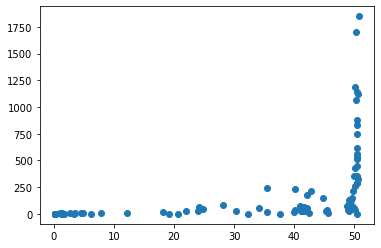

In [39]:
plt.scatter(pred, y_val[1:100])

## Generating submission


In [37]:
test_data = pd.read_csv(path+"test.csv")
test_data.head()

,ForecastId,Province_State,Country_Region,Date
0,1,NaN,Afghanistan,2020-03-26
1,2,NaN,Afghanistan,2020-03-27
2,3,NaN,Afghanistan,2020-03-28
3,4,NaN,Afghanistan,2020-03-29
4,5,NaN,Afghanistan,2020-03-30


In [4]:
test_data["isCountry"] = test_data.Province_State.isna()
test_data.Province_State[test_data.Province_State.isna()] = ""
test_data["Region"]= test_data.Country_Region 
test_data["Region"][~test_data.isCountry]= test_data.Country_Region + "-" + test_data.Province_State

number_of_rows = test_data.shape[0]
registers_count_by_region_test = test_data[["ForecastId", "Region"]].groupby("Region").count()
registers_count_by_region_test.columns = ["Count"]
registers_count_by_region_test.reset_index(inplace=True)#
days_test = np.unique(test_data.Date)
n_days_test = len(days_test)

NameError: name 'test_data' is not defined

In [3]:
test_data

NameError: name 'test_data' is not defined

In [40]:
days_test

array(['2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29',
       '2020-03-30', '2020-03-31', '2020-04-01', '2020-04-02',
       '2020-04-03', '2020-04-04', '2020-04-05', '2020-04-06',
       '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10',
       '2020-04-11', '2020-04-12', '2020-04-13', '2020-04-14',
       '2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18',
       '2020-04-19', '2020-04-20', '2020-04-21', '2020-04-22',
       '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26',
       '2020-04-27', '2020-04-28', '2020-04-29', '2020-04-30',
       '2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04',
       '2020-05-05', '2020-05-06', '2020-05-07'], dtype=object)

In [49]:
days_to_predict = [dtime.strftime(dtime.strptime(days[-1],  "%Y-%m-%d")+timedelta(i), "%Y-%m-%d") for i in range(1,31)]
n_days_to_predict = len(days_to_predict)
concat_df = pd.DataFrame()
print(days_to_predict)
for i, region in enumerate(regions):
    
    data_region = data[data.Region == region][data.TenConfirmed==True]
    
    if (data_region.shape[0]==0):
        data_region = data[data.Region == region][data.FirstConfirmed==True]
        
    try:
        state = df_merged2[df_merged2.Region==region].state.iloc[0]
    except:
        state = 0
        
    
        
    temp_df = pd.DataFrame({"Date":days_to_predict, "Country_Region": [data_region.Country_Region.iloc[0]]*n_days_to_predict, 
                            "Province_State": [data_region.Province_State.iloc[0]]*n_days_to_predict,
                            "isCountry": [data_region.isCountry.iloc[0]]*n_days_to_predict})

    temp_df["Region"]= temp_df.Country_Region 
    temp_df["Region"][~temp_df.isCountry] = temp_df.Country_Region + "-" + temp_df.Province_State
    
    ts_confirmed = data_region.NewConfirmed
    ts_fatalities = data_region.NewFatalities
    
    ma_conf = np.convolve(ts_confirmed, np.ones((N,))/N, mode='same')
    ma_fat = np.convolve(ts_fatalities, np.ones((N,))/N, mode='same')
    
    current_day_confirmed = data_region.DayFromTenConfirmed.iloc[-1]
    current_day_fatalities = data_region.DayFromTenFatality.iloc[-1]
    
    current_confirmed = data_region.ConfirmedCases.iloc[-1]
    current_fatalities = data_region.Fatalities.iloc[-1]
        
    if(state==1):
        func = sigmoid
    else:
        func = exponential
    
    try:
        predicted_confirmed, predicted_fatalities = simple_predictor(func, ma_conf, ma_fat, current_day_confirmed, current_day_fatalities, n_days_to_predict)
        
        predicted_confirmed[0] = predicted_confirmed[0] + current_confirmed
        predicted_confirmed = np.cumsum(predicted_confirmed)
        
        predicted_fatalities[0] = predicted_fatalities[0] + current_fatalities
        predicted_fatalities = np.cumsum(predicted_fatalities)
    
    except:
        
        predicted_confirmed = [0]*n_days_to_predict
        predicted_fatalities = [0]*n_days_to_predict
        predicted_confirmed[0], predicted_fatalities[0] = current_confirmed, current_fatalities
        predicted_confirmed = np.cumsum(predicted_confirmed)
        predicted_fatalities = np.cumsum(predicted_fatalities)
    
    temp_df["ConfirmedCases"] = predicted_confirmed
    temp_df["Fatalities"] = predicted_fatalities
    concat_df = pd.concat([concat_df, temp_df])

['2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13', '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19', '2020-04-20', '2020-04-21', '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26', '2020-04-27', '2020-04-28', '2020-04-29', '2020-04-30', '2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-07']


In [50]:
current_data = data[["Date", "Country_Region", "Province_State", "ConfirmedCases", "Fatalities", "Region"]]


In [51]:
concat_df

,Date,Country_Region,Province_State,isCountry,Region,ConfirmedCases,Fatalities
0,2020-04-08,Afghanistan,,True,Afghanistan,423.0,14.0
1,2020-04-09,Afghanistan,,True,Afghanistan,423.0,14.0
2,2020-04-10,Afghanistan,,True,Afghanistan,423.0,14.0
3,2020-04-11,Afghanistan,,True,Afghanistan,423.0,14.0
4,2020-04-12,Afghanistan,,True,Afghanistan,423.0,14.0
...,...,...,...,...,...,...,...
25,2020-05-03,Zimbabwe,,True,Zimbabwe,13.6,4.6
26,2020-05-04,Zimbabwe,,True,Zimbabwe,13.7,4.7
27,2020-05-05,Zimbabwe,,True,Zimbabwe,13.8,4.8
28,2020-05-06,Zimbabwe,,True,Zimbabwe,13.9,4.9


In [52]:
submission1 = test_data.merge(current_data, on=["Region", "Date"] ,  how='left')


In [53]:
submission1 

,ForecastId,Province_State_x,Country_Region_x,Date,isCountry,Region,Country_Region_y,Province_State_y,ConfirmedCases,Fatalities
0,1,,Afghanistan,2020-03-26,True,Afghanistan,Afghanistan,,94.0,4.0
1,2,,Afghanistan,2020-03-27,True,Afghanistan,Afghanistan,,110.0,4.0
2,3,,Afghanistan,2020-03-28,True,Afghanistan,Afghanistan,,110.0,4.0
3,4,,Afghanistan,2020-03-29,True,Afghanistan,Afghanistan,,120.0,4.0
4,5,,Afghanistan,2020-03-30,True,Afghanistan,Afghanistan,,170.0,4.0
...,...,...,...,...,...,...,...,...,...,...
13153,13154,,Zimbabwe,2020-05-03,True,Zimbabwe,NaN,NaN,NaN,NaN
13154,13155,,Zimbabwe,2020-05-04,True,Zimbabwe,NaN,NaN,NaN,NaN
13155,13156,,Zimbabwe,2020-05-05,True,Zimbabwe,NaN,NaN,NaN,NaN
13156,13157,,Zimbabwe,2020-05-06,True,Zimbabwe,NaN,NaN,NaN,NaN


In [54]:
submission2 = submission1.merge(concat_df, on= ["Region", "Date"], how="left")

In [55]:
submission2[submission2.Region=="Spain"].head()

,ForecastId,Province_State_x,Country_Region_x,Date,isCountry_x,Region,Country_Region_y,Province_State_y,ConfirmedCases_x,Fatalities_x,Country_Region,Province_State,isCountry_y,ConfirmedCases_y,Fatalities_y
9331,9332,,Spain,2020-03-26,True,Spain,Spain,,57786.0,4365.0,NaN,NaN,NaN,NaN,NaN
9332,9333,,Spain,2020-03-27,True,Spain,Spain,,65719.0,5138.0,NaN,NaN,NaN,NaN,NaN
9333,9334,,Spain,2020-03-28,True,Spain,Spain,,73235.0,5982.0,NaN,NaN,NaN,NaN,NaN
9334,9335,,Spain,2020-03-29,True,Spain,Spain,,80110.0,6803.0,NaN,NaN,NaN,NaN,NaN
9335,9336,,Spain,2020-03-30,True,Spain,Spain,,87956.0,7716.0,NaN,NaN,NaN,NaN,NaN


In [56]:
submission2["ConfirmedCases"] = submission2[["ConfirmedCases_x", "ConfirmedCases_y"]].apply(lambda x: x[0] if ~np.isnan(x[0]) else x[1], axis=1)
submission2["Fatalities"] = submission2[["Fatalities_x", "Fatalities_y"]].apply(lambda x: x[0] if ~np.isnan(x[0]) else x[1], axis=1)

In [57]:
submission_data = pd.read_csv(path+"submission.csv")#
submission_data

,Unnamed: 0,ForecastId,ConfirmedCases,Fatalities
0,0,1,94.000000,4.000000
1,1,2,110.000000,4.000000
2,2,3,110.000000,4.000000
3,3,4,120.000000,4.000000
4,4,5,170.000000,4.000000
...,...,...,...,...
13153,13153,13154,17.360702,2.656991
13154,13154,13155,17.622503,2.728464
13155,13155,13156,17.883810,2.800175
13156,13156,13157,18.144625,2.872094


In [58]:
submission3 = submission_data[["ForecastId"]].merge(submission2[["ForecastId", "ConfirmedCases", "Fatalities" ]], on= "ForecastId", how="left")

submission3 = submission3.astype("int32")

In [59]:
submission3.to_csv("submission.csv", index=False)

## Other data sources:

- https://raw.githubusercontent.com/resbaz/r-novice-gapminder-files/master/data/gapminder-FiveYearData.csv
- https://data.humdata.org/dataset/oxford-covid-19-government-response-tracker
- Enriched data: https://www.kaggle.com/optimo/covid19-enriched-dataset
- https://ourworldindata.org/coronavirus#all-charts-preview

## Technical info:

- https://www.tensorflow.org/tutorials/structured_data/time_series
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Attention